In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import pickle
import os
import glob
import sys

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
os.chdir(home_directory) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Image_vs_spectra import *
from Py_files.Convolution_script import *
image_files, filter_files = generate_list_of_files()
locations = [[202.5062429, 47.2143358], [202.4335225, 47.1729608], [202.4340450, 47.1732517], [202.4823742, 47.1958589]]
radius = 0.75*u.arcsec
thickness = 0.1*u.arcsec

True
/d/ret1/Taylor/stpsf-data/


In [2]:
def get_annulus_flux(image_file, location, radius, thickness):
    big_flux = get_image_flux(image_file, location, radius)
    little_flux = get_image_flux(image_file, location, u.arcsec*max((radius-thickness).value, 1e-6))
    return big_flux - little_flux
get_annulus_flux(image_files[0], locations[0], radius, thickness)

2.4525001110505095e-31

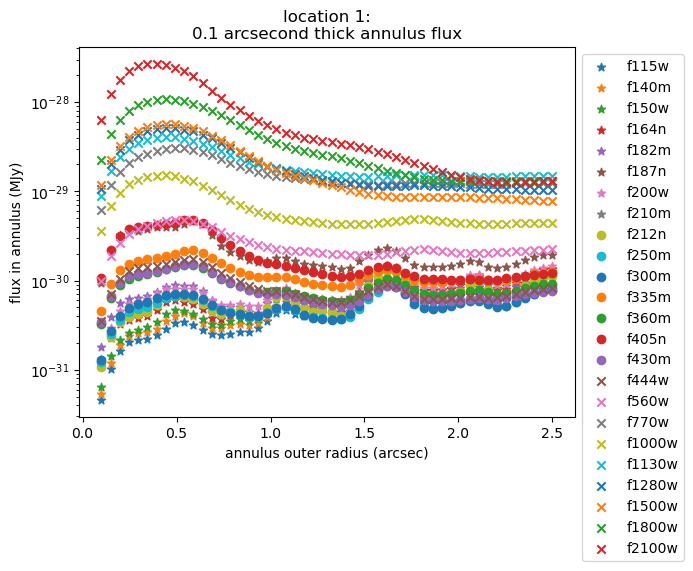

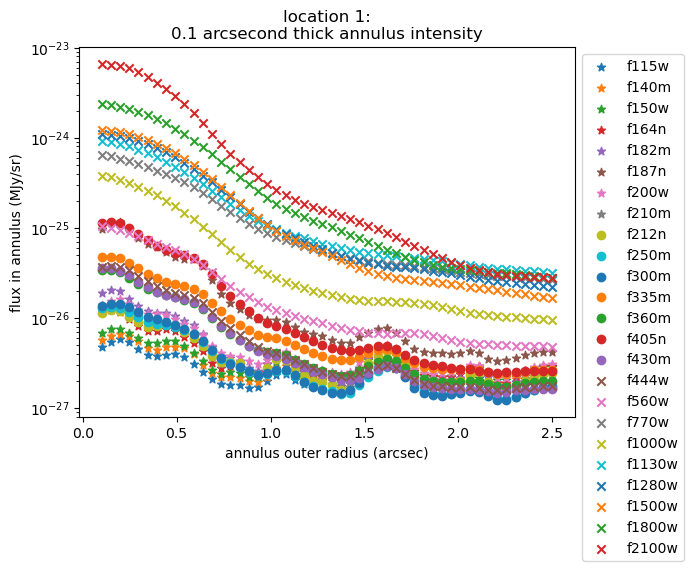

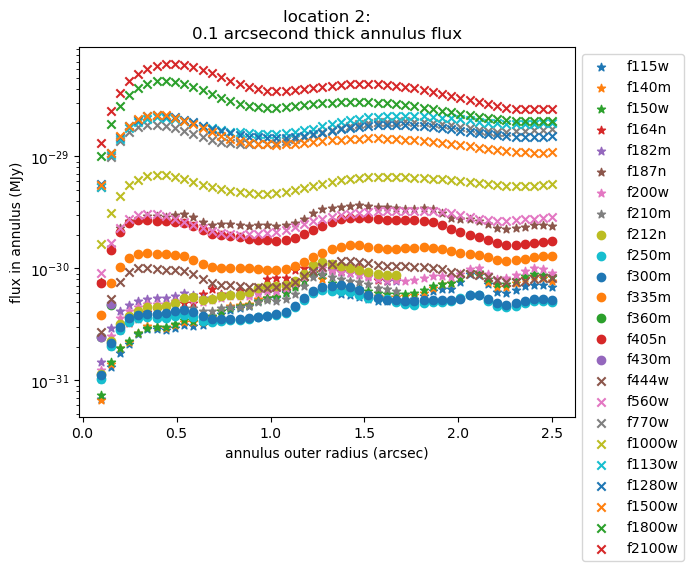

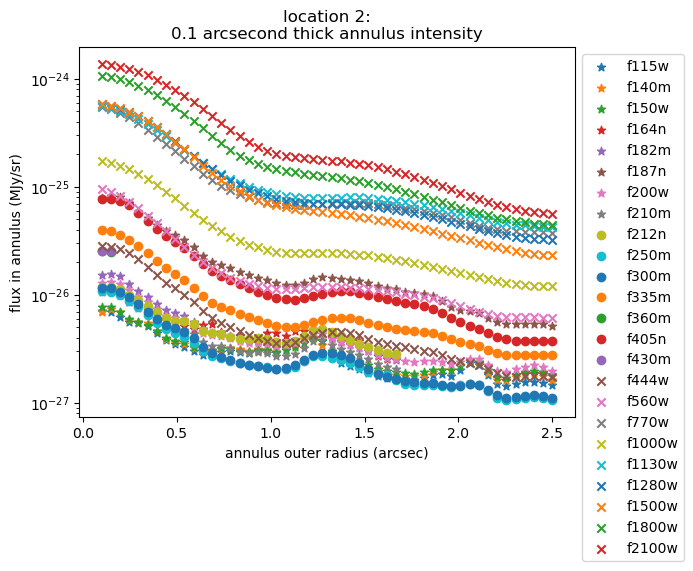

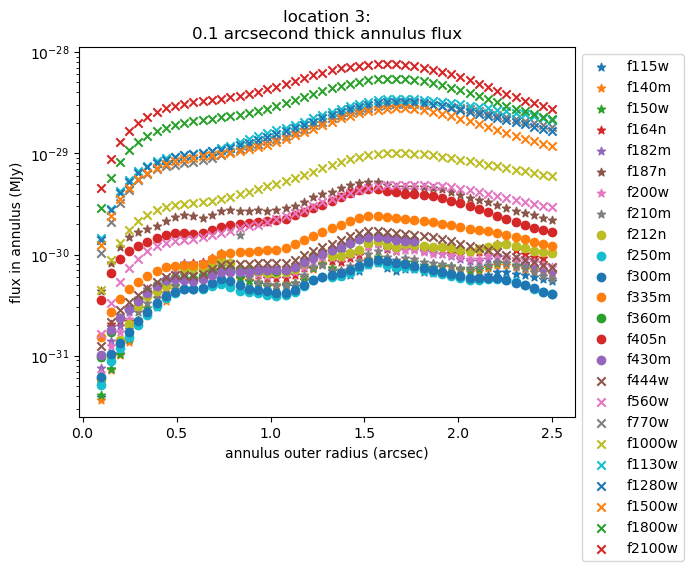

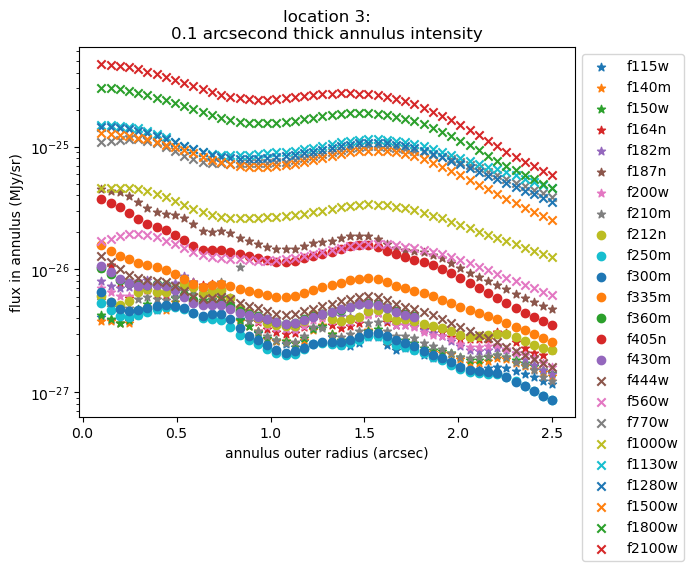

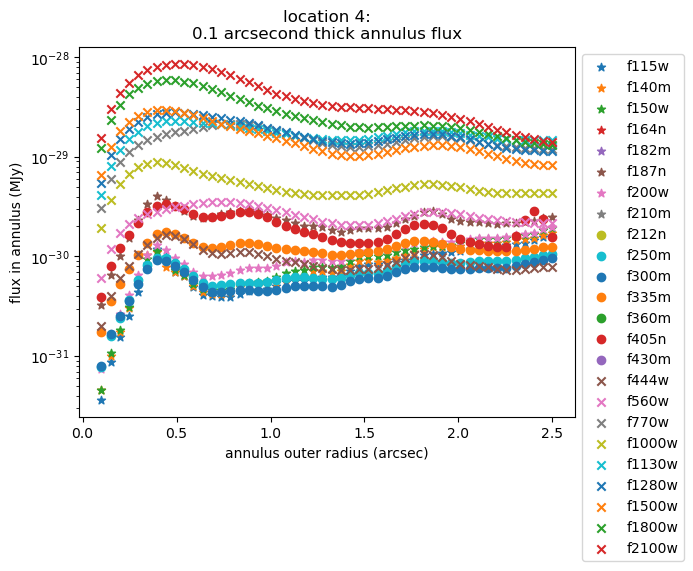

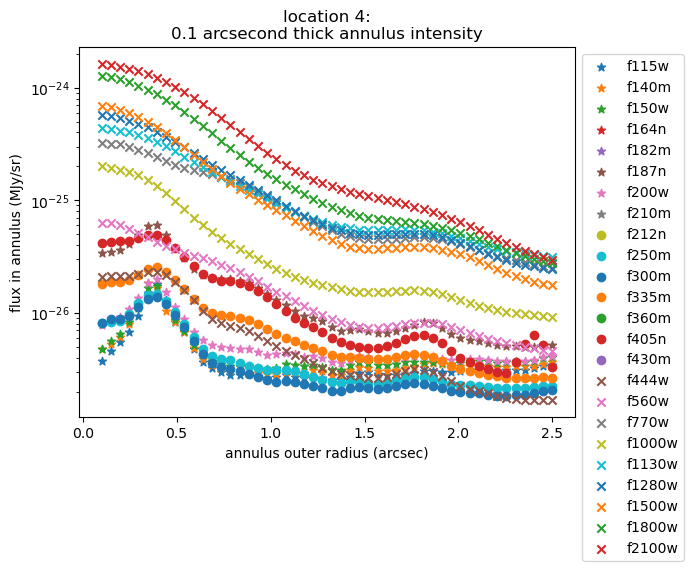

In [12]:
for l, test_loc in enumerate(locations):
        
    all_peak_locations = []
    falloff = []
    filter_names = [extract_filter_name(image_file) for image_file in image_files]
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    
    for i, file in enumerate(image_files):
        if i < 8:
            marker = '*'
        elif i < 15:
            marker = 'o'
        else:
            marker = 'x'
            
        annulus_flux = []
        annulus_radius = []
        annulus_area = []
        annulus_intensity = []
        effective_radius = None
        for r1 in np.linspace(0.1, 2.5, 50):
            out_radius = r1*u.arcsec
            flux = get_annulus_flux(file, test_loc, out_radius, thickness)
            area = (np.pi*(((r1**2 - (r1-thickness.value)**2)*u.deg**2).to(u.sr))).value
            annulus_flux.append(flux)
            annulus_radius.append(r1)
            annulus_area.append(area)
            annulus_intensity.append(flux/area)
            if r1==0.1:
                baseline = flux/area
            if (flux/area < 0.5*baseline) and (effective_radius == None):
                effective_radius = True
                falloff.append(r1)
        if effective_radius == None:
            falloff.append(r1)
        annulus_flux = np.array(annulus_flux)
        annulus_radius = np.array(annulus_radius)
        annulus_area = np.array(annulus_area)
        annulus_intensity = np.array(annulus_intensity)
        dy = np.diff(annulus_flux)
        for j in range(len(dy)-1):
            if dy[j] > 0 and dy[j+1] < 0:
                # Save the corresponding x-location (approximate the peak at j+1)
                peak = annulus_area[j+1]
        
        all_peak_locations.append(peak)
    
        ax1.scatter(annulus_radius, annulus_flux, label=f'{extract_filter_name(file)}', marker = marker)
        ax2.scatter(annulus_radius, annulus_intensity, label=f'{extract_filter_name(file)}', marker = marker)
    falloff = np.array(falloff)
    ax1.set_yscale('log')
    ax1.set_xlabel('annulus outer radius (arcsec)')
    ax1.set_ylabel('flux in annulus (MJy)')
    ax1.set_title(f'location {l+1}:\n0.1 arcsecond thick annulus flux')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Format the second plot
    ax2.set_yscale('log')
    ax2.set_xlabel('annulus outer radius (arcsec)')
    ax2.set_ylabel('flux in annulus (MJy/sr)')
    ax2.set_title(f'location {l+1}:\n0.1 arcsecond thick annulus intensity')
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Show both plots
    plt.show(fig1)
    plt.show(fig2)
    
    #plt.scatter(filter_names, falloff, marker = 'x')
    #plt.xlabel('filter name')
    #plt.ylabel('radius where intensity is 50% maximum')
    #plt.title(f'location {l+1}:\ncomparing falloff rate of annular intensity')
    #plt.xticks(rotation = 45)
    #plt.show()

24


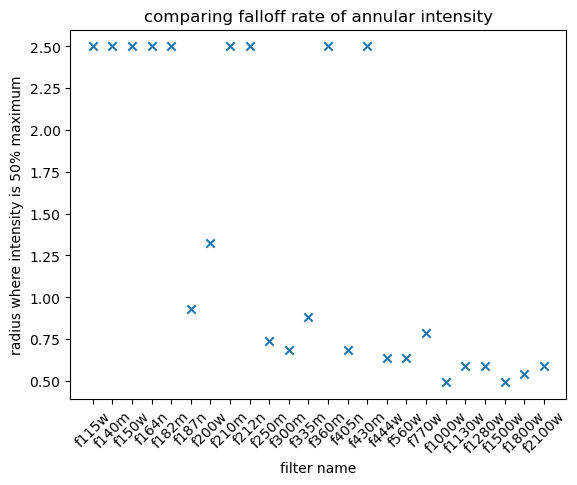

In [5]:
print(len(falloff))
plt.scatter(filter_names, falloff, marker = 'x')
plt.xlabel('filter name')
plt.ylabel('radius where intensity is 50% maximum')
plt.title('comparing falloff rate of annular intensity')
plt.xticks(rotation = 45)
plt.show()

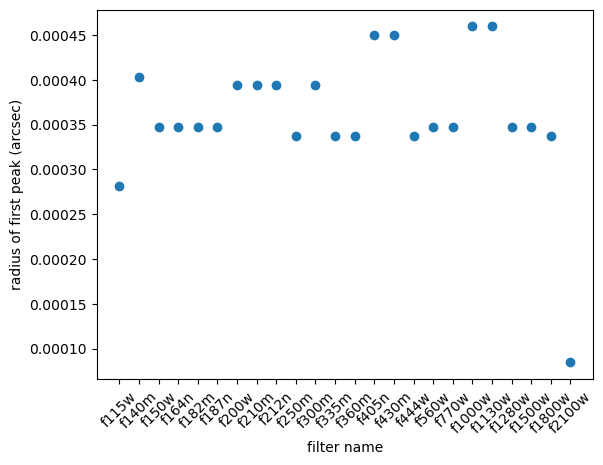

In [6]:
plt.scatter(filter_names, all_peak_locations)
plt.xlabel('filter name')
plt.ylabel('radius of first peak (arcsec)')
plt.xticks(rotation = 45)
plt.show()

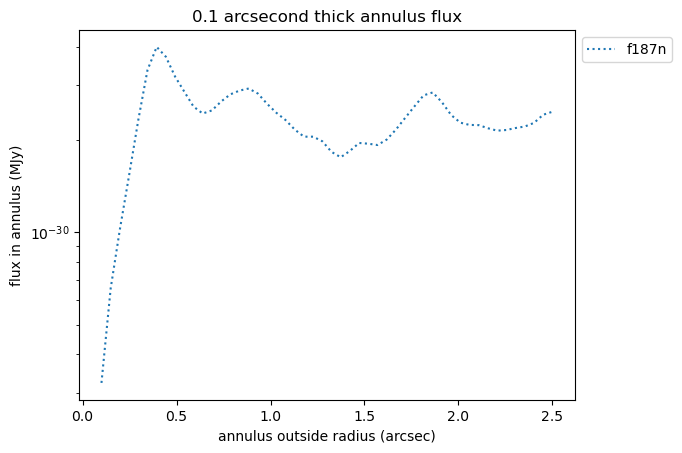

In [7]:
file = image_files[5]
annulus_flux = []
annulus_size = []
for r1 in np.linspace(0.1, 2.5, 50):
    out_radius = r1*u.arcsec
    annulus_flux.append(get_annulus_flux(file, test_loc, out_radius, thickness))
    annulus_size.append(r1)
plt.plot(annulus_size, annulus_flux, label = f'{extract_filter_name(file)}', linestyle = 'dotted')
plt.yscale('log')
plt.xlabel('annulus outside radius (arcsec)')
plt.ylabel('flux in annulus (MJy)')
plt.title('0.1 arcsecond thick annulus flux')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

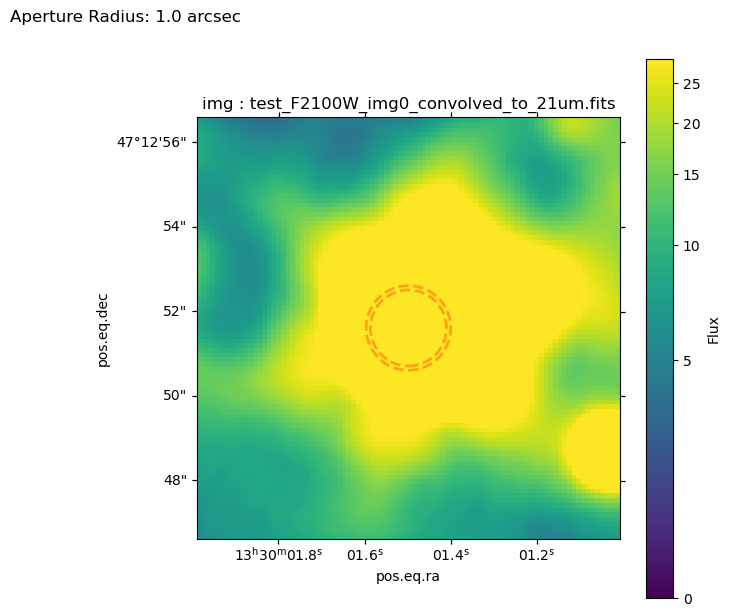

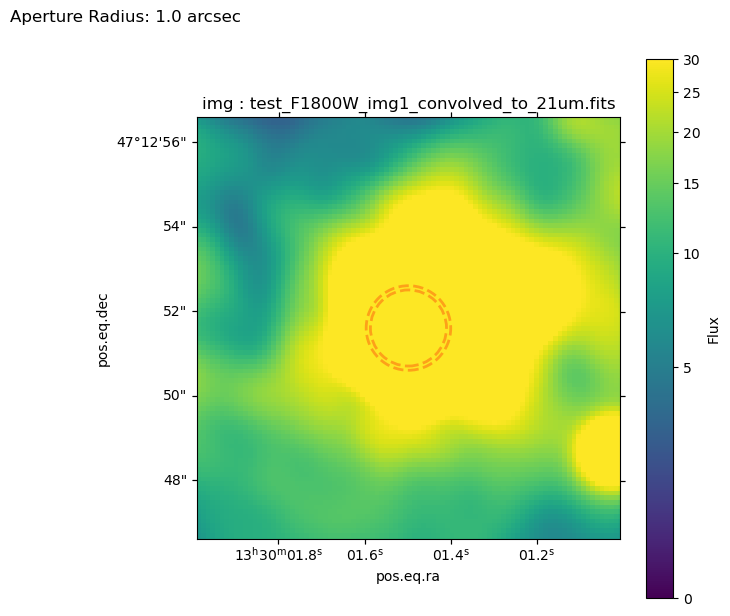

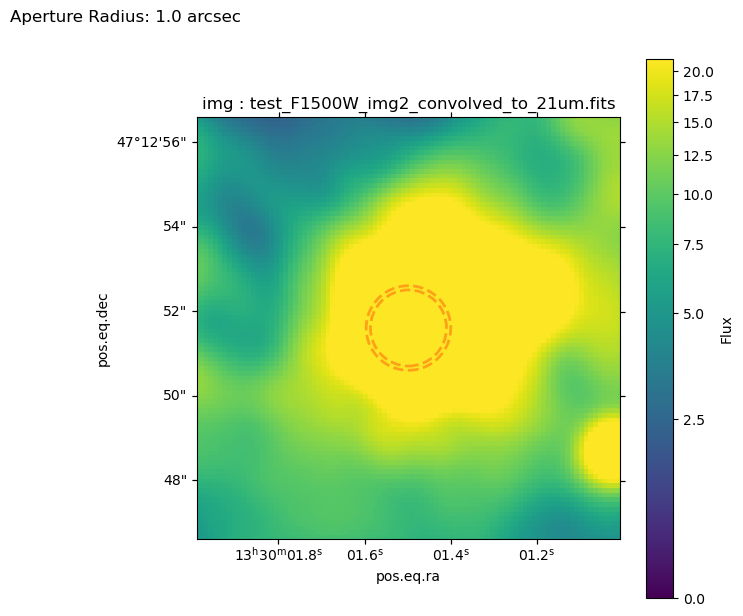

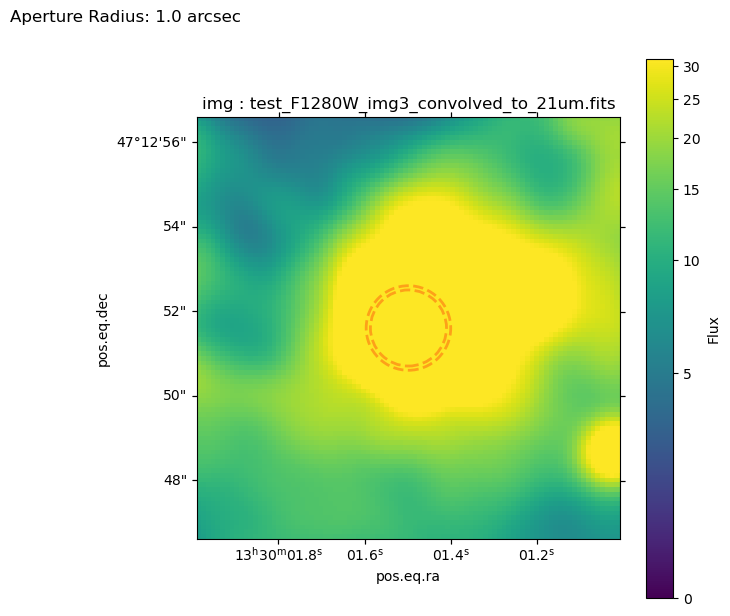

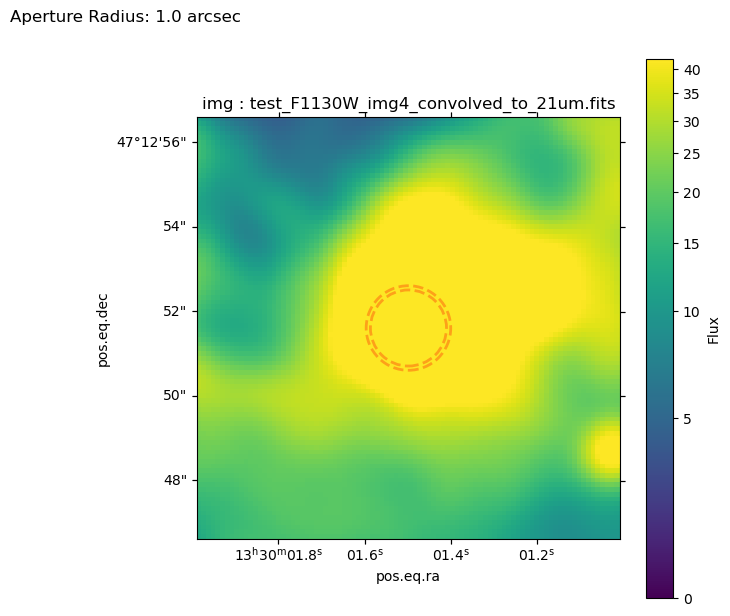

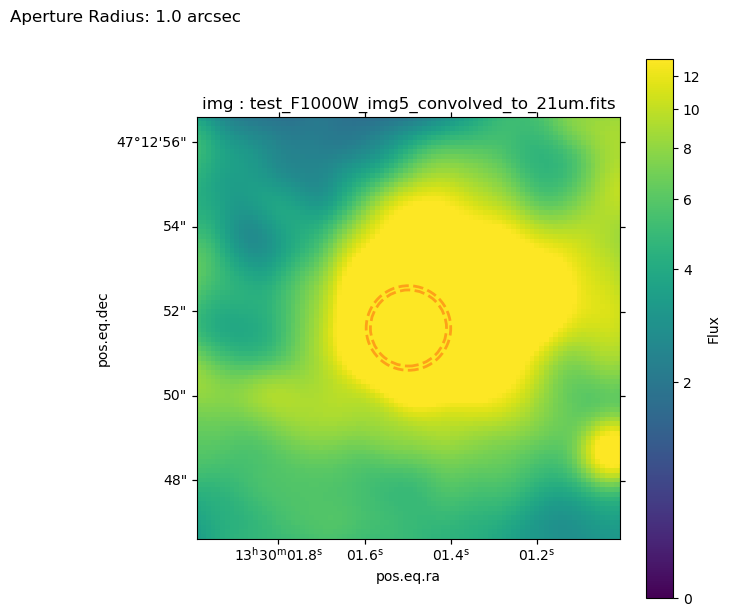

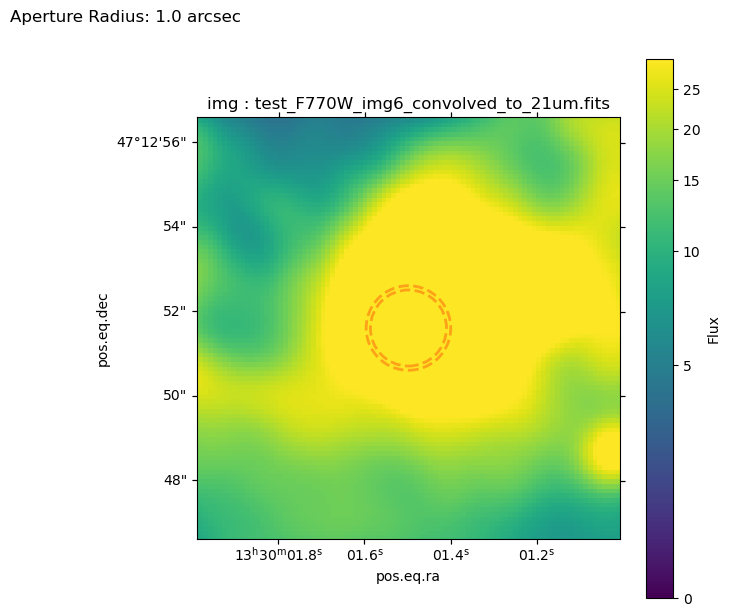

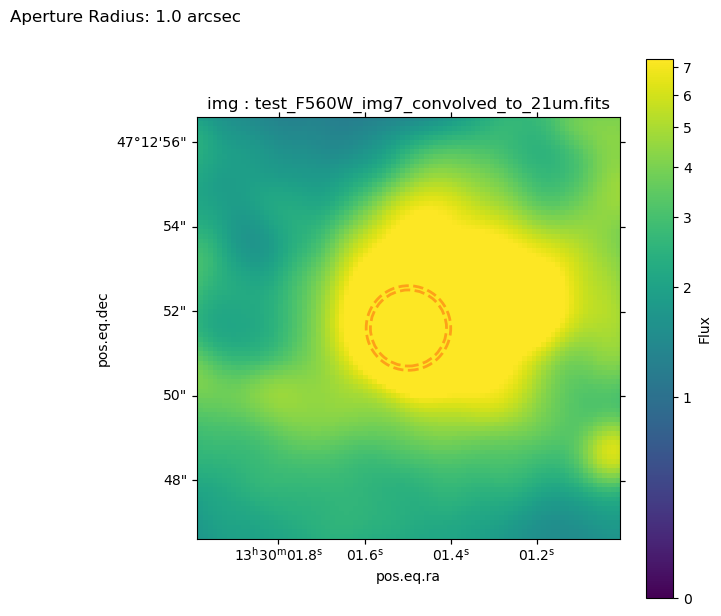

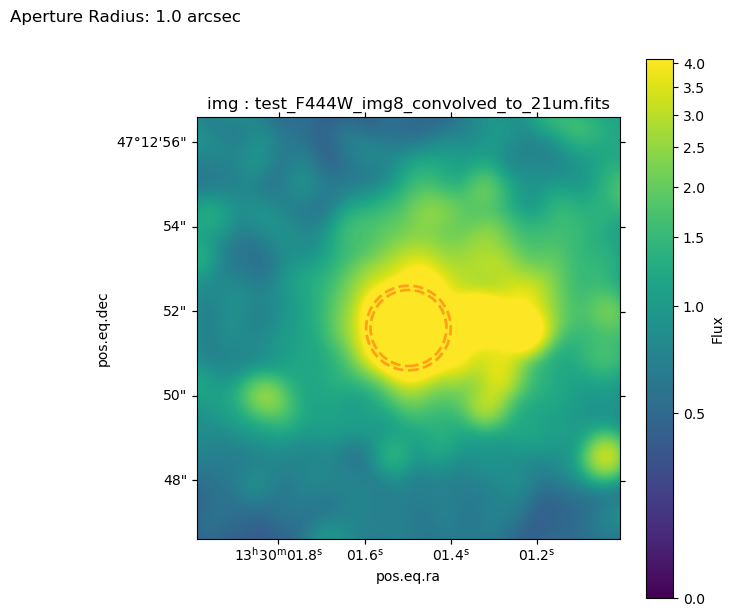

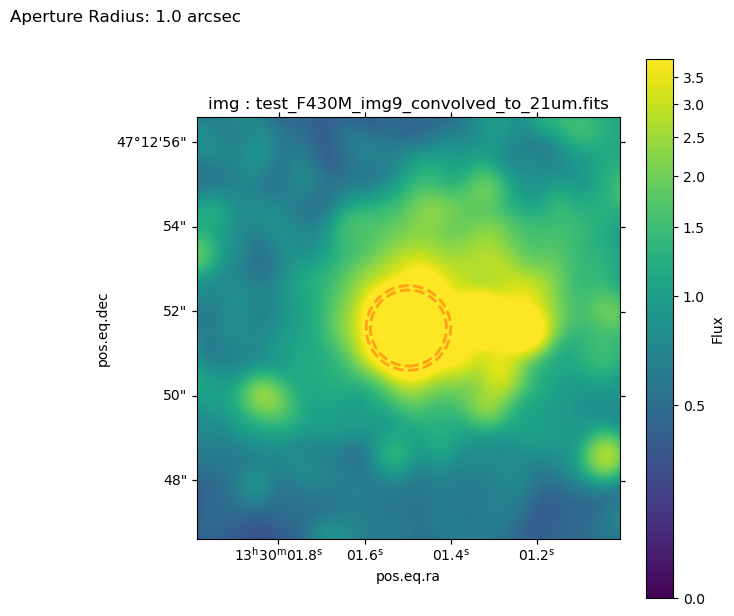

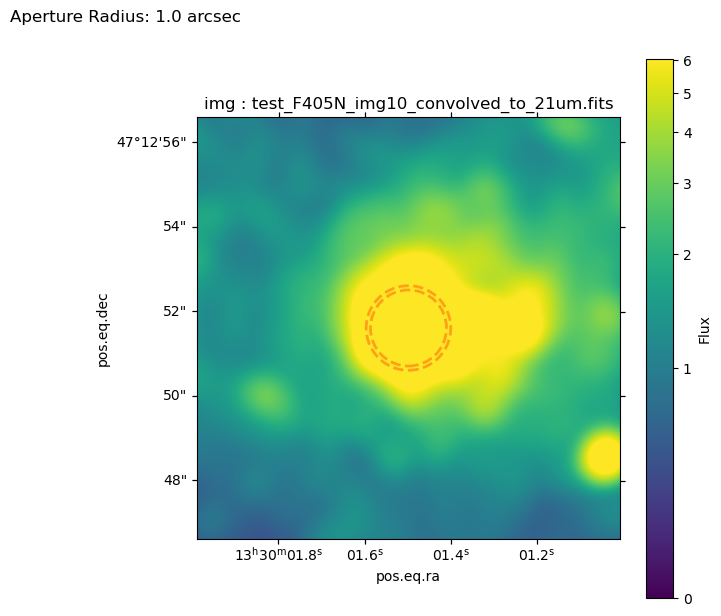

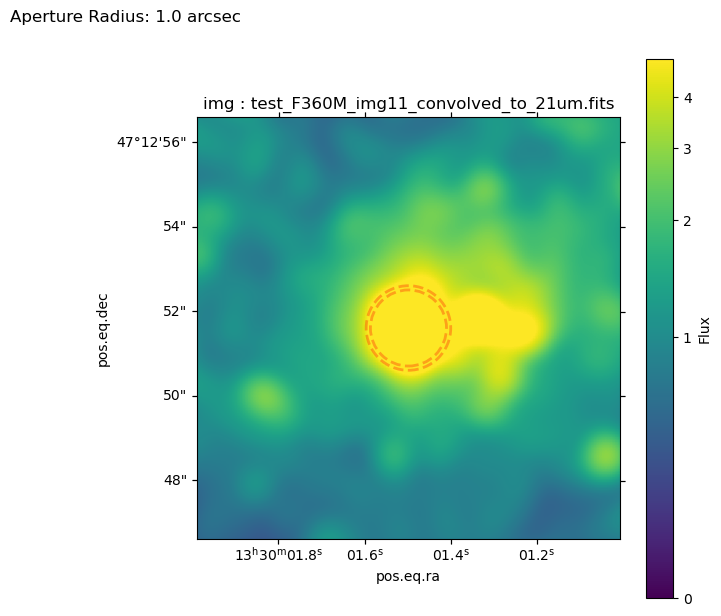

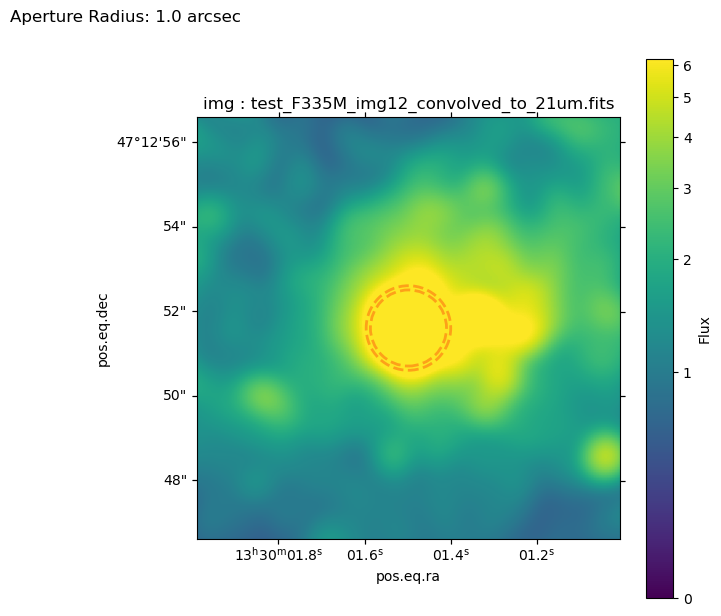

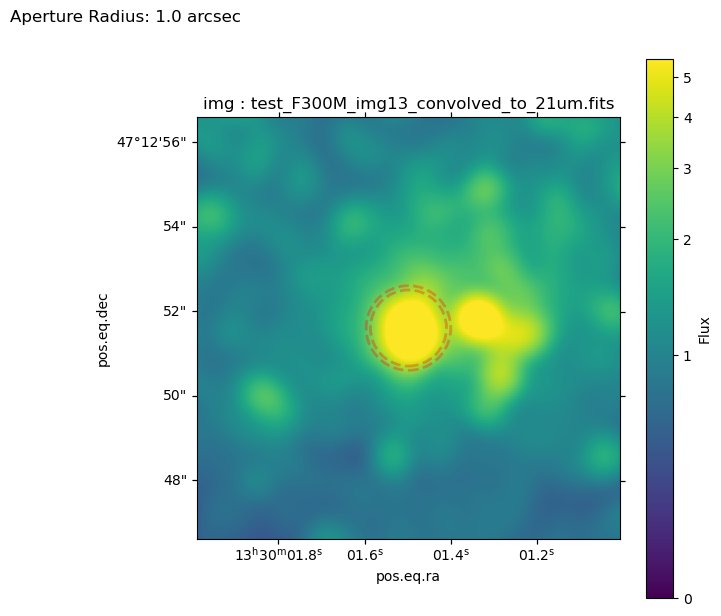

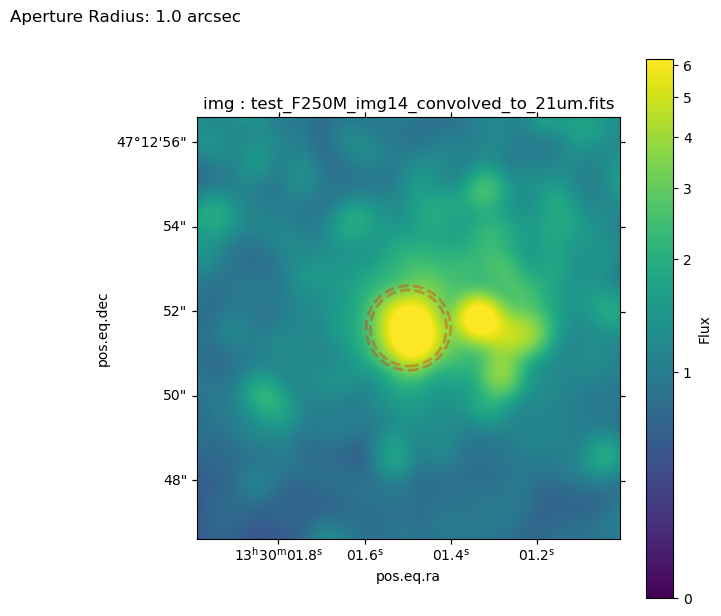

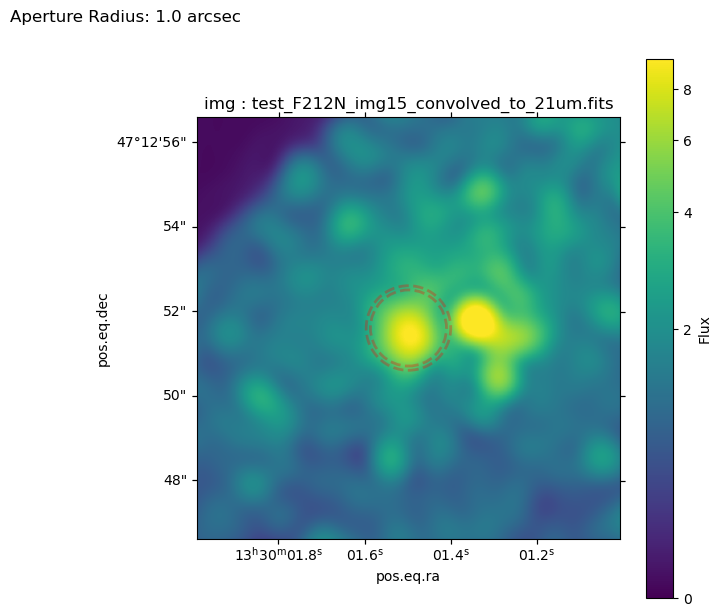

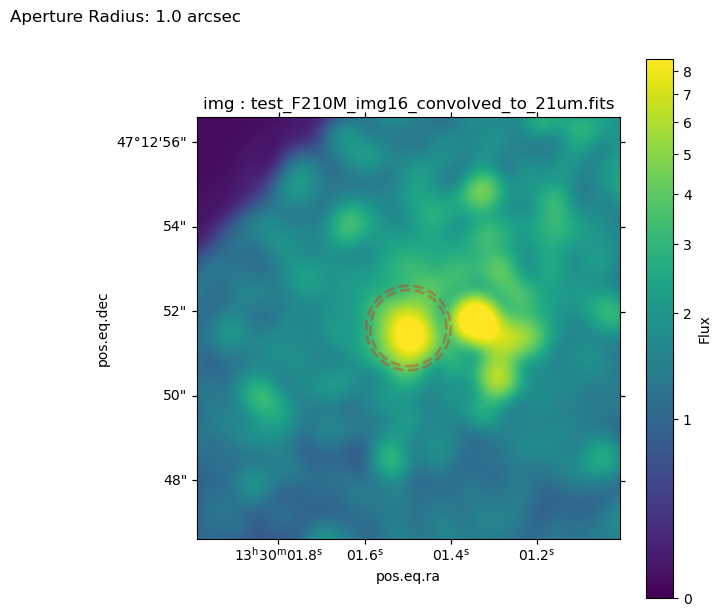

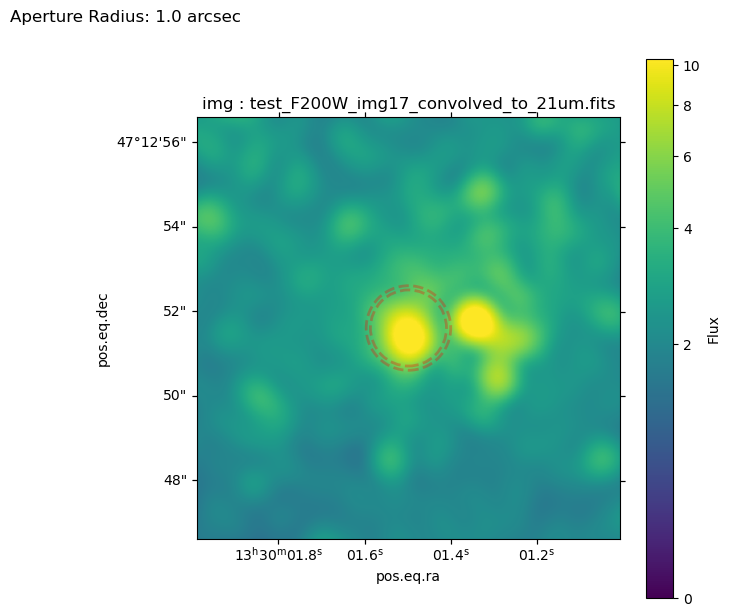

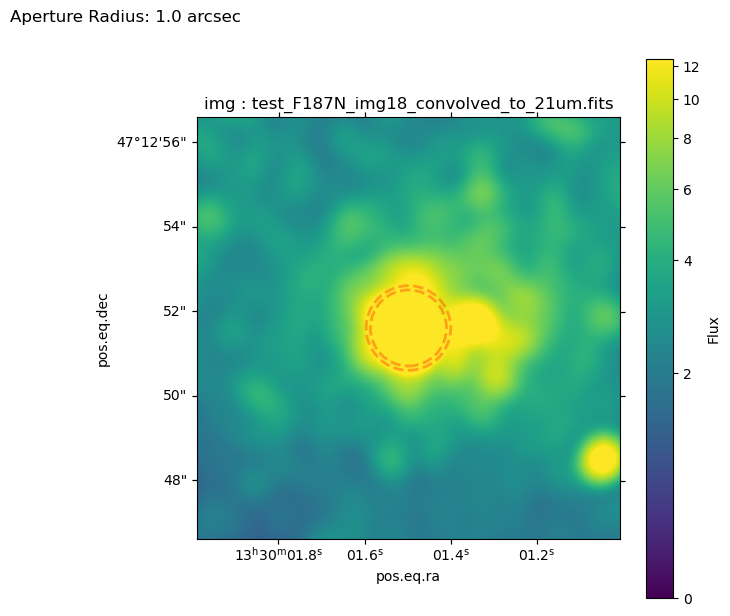

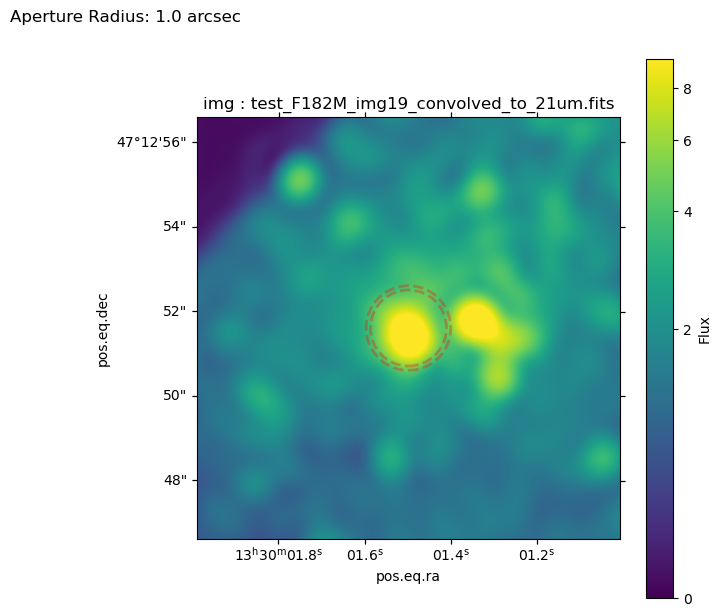

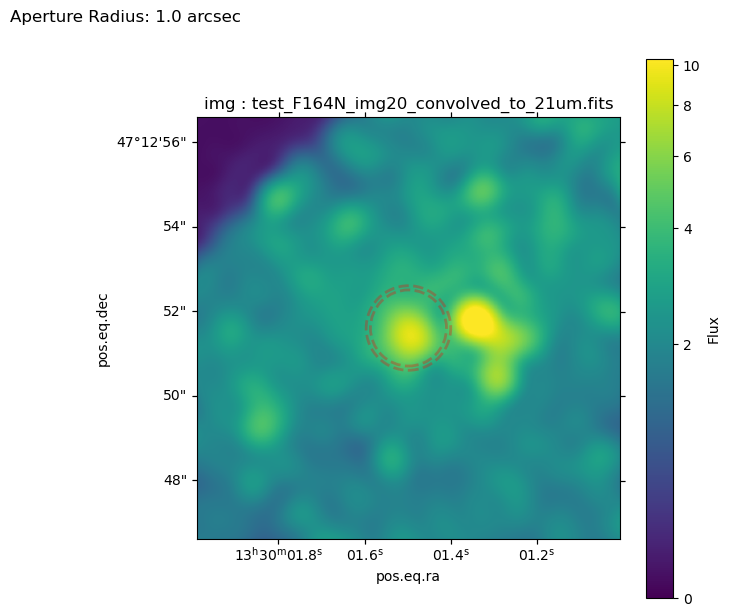

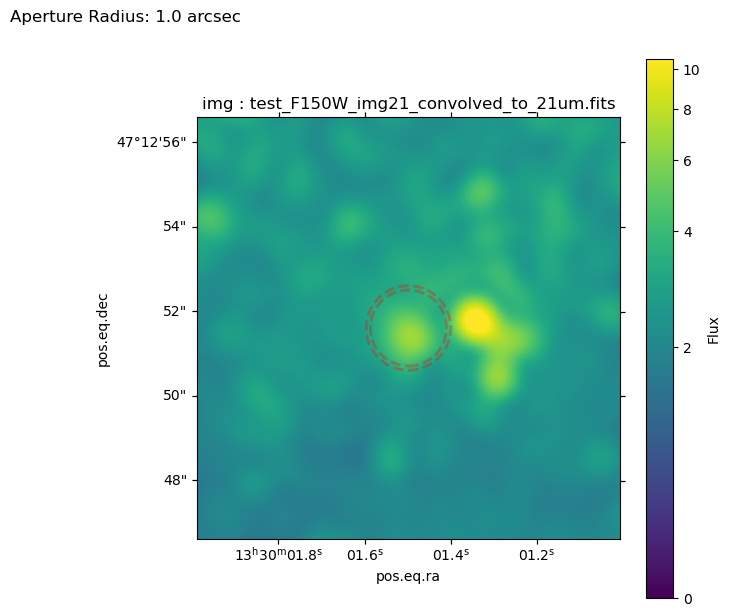

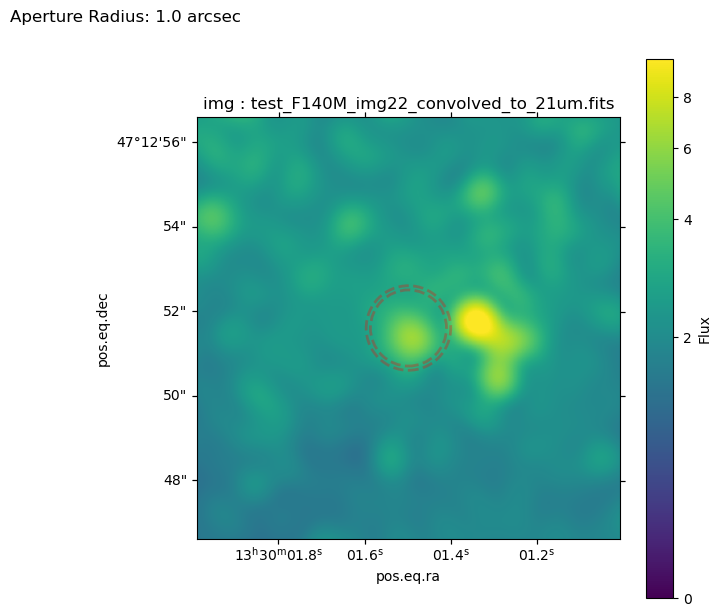

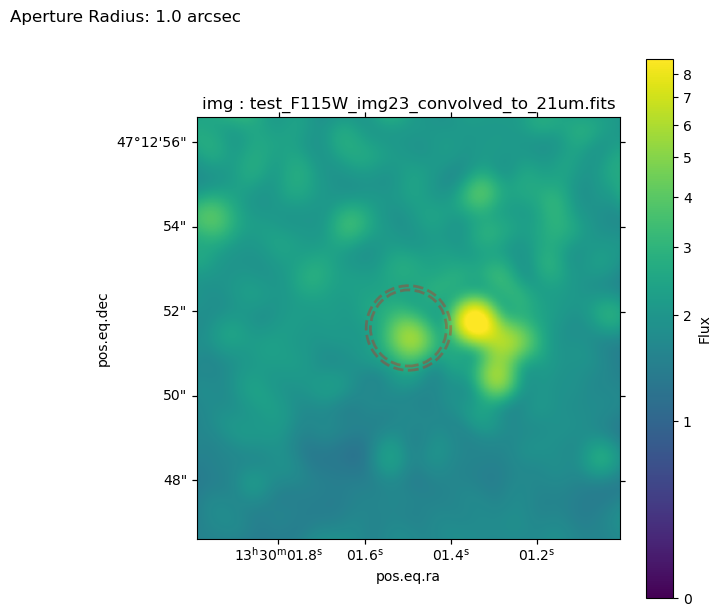

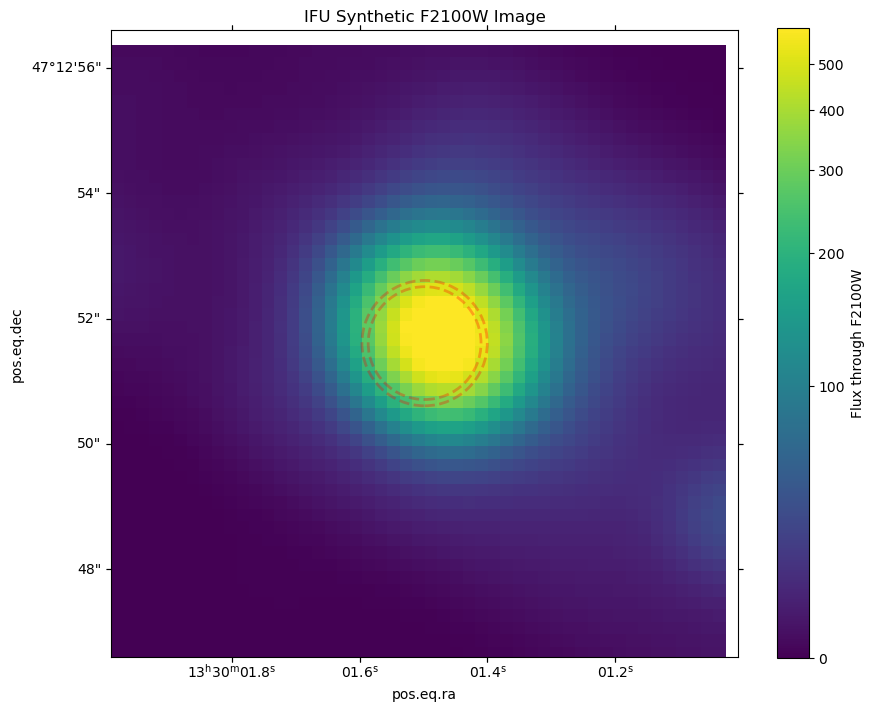

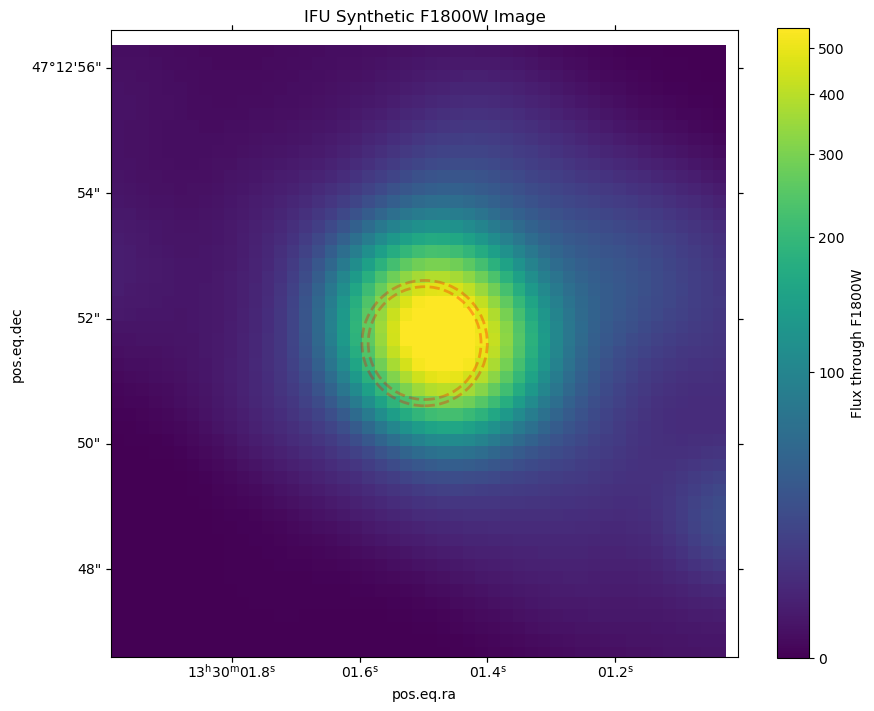

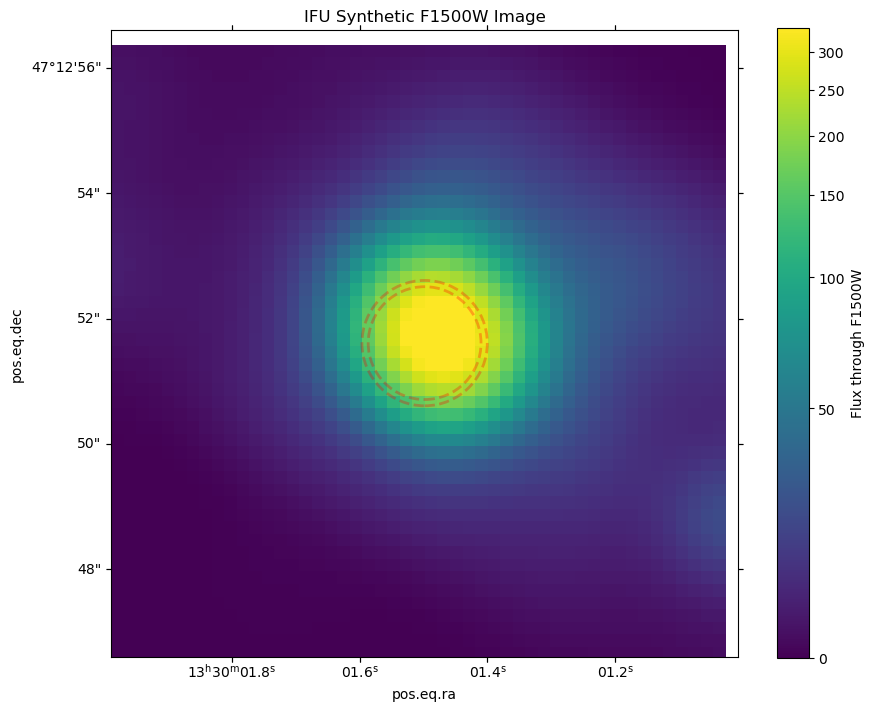

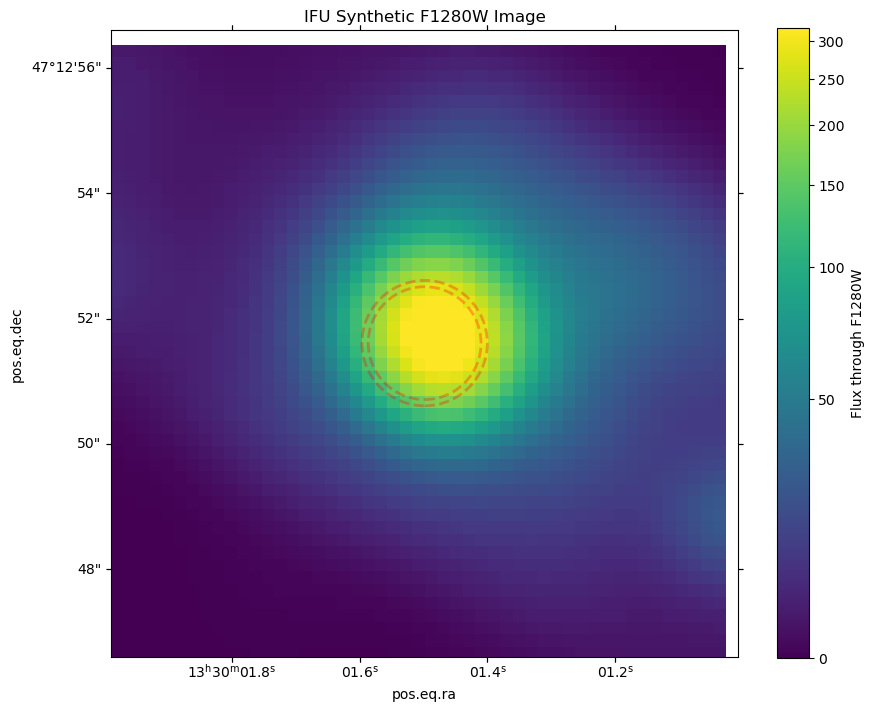

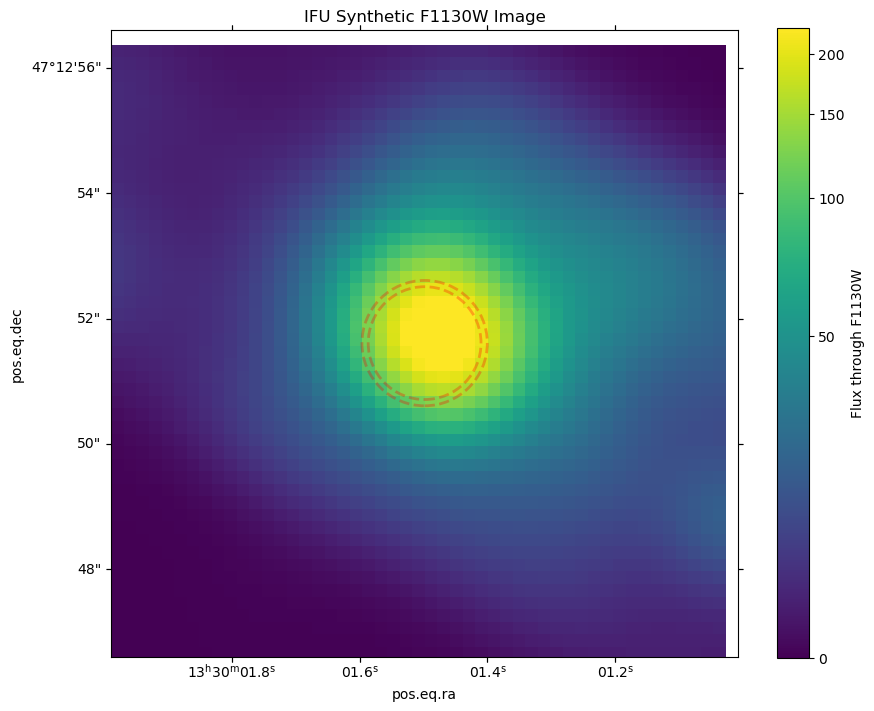

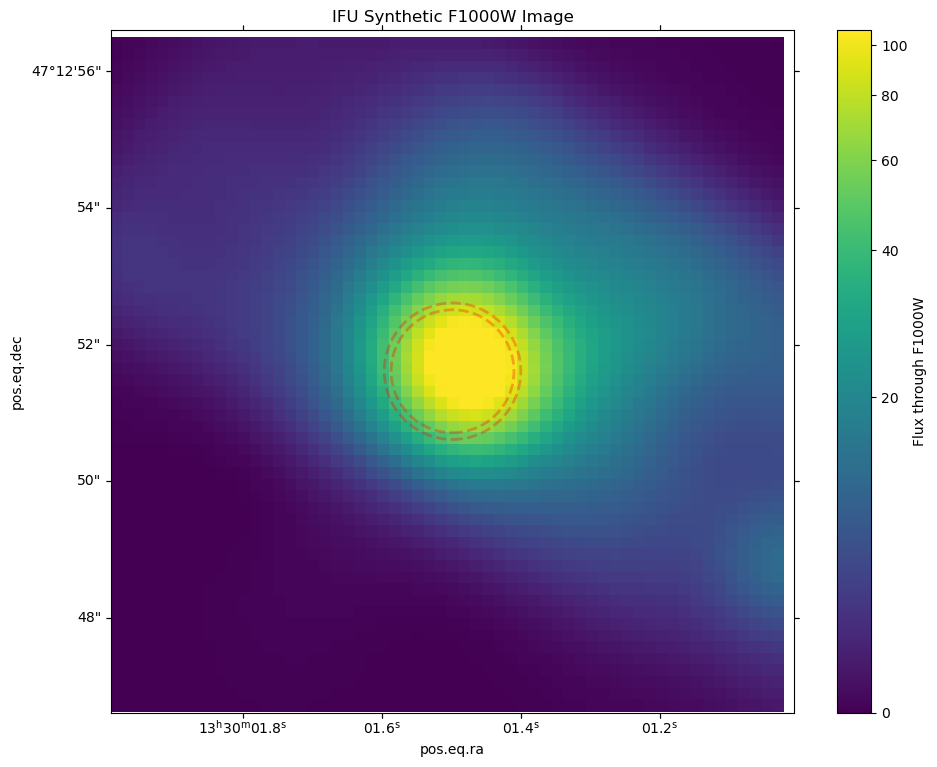

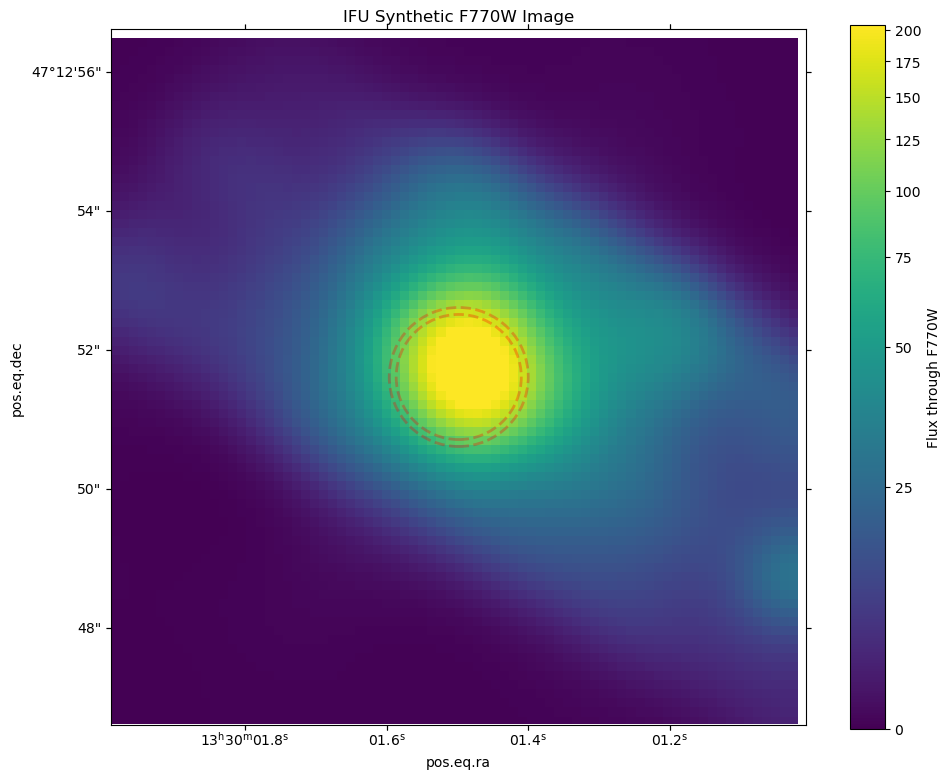

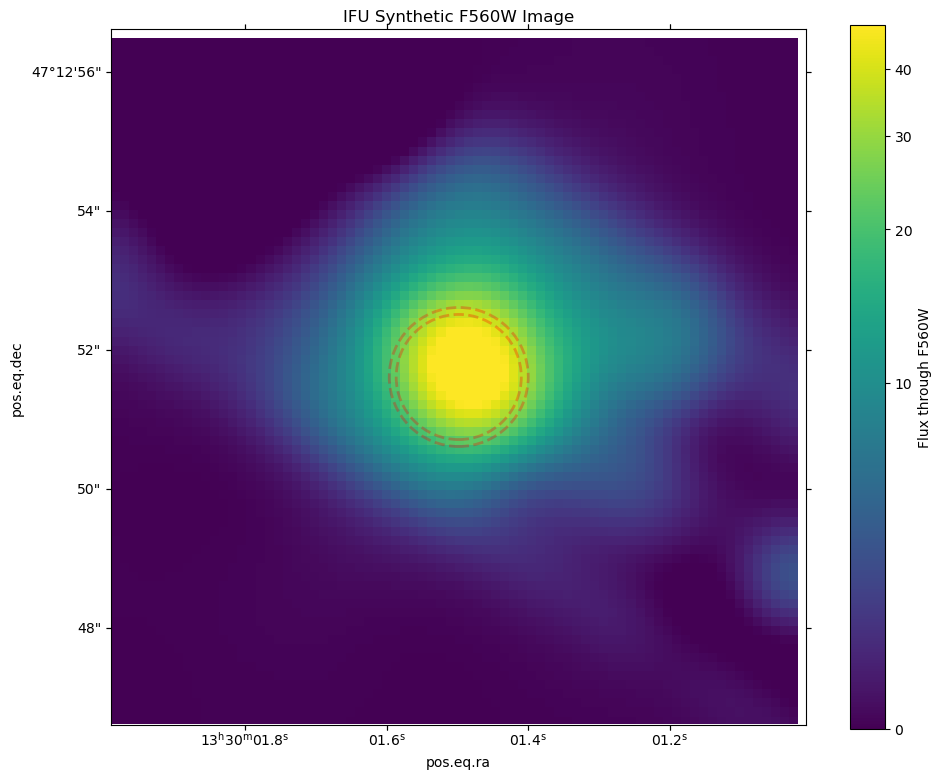

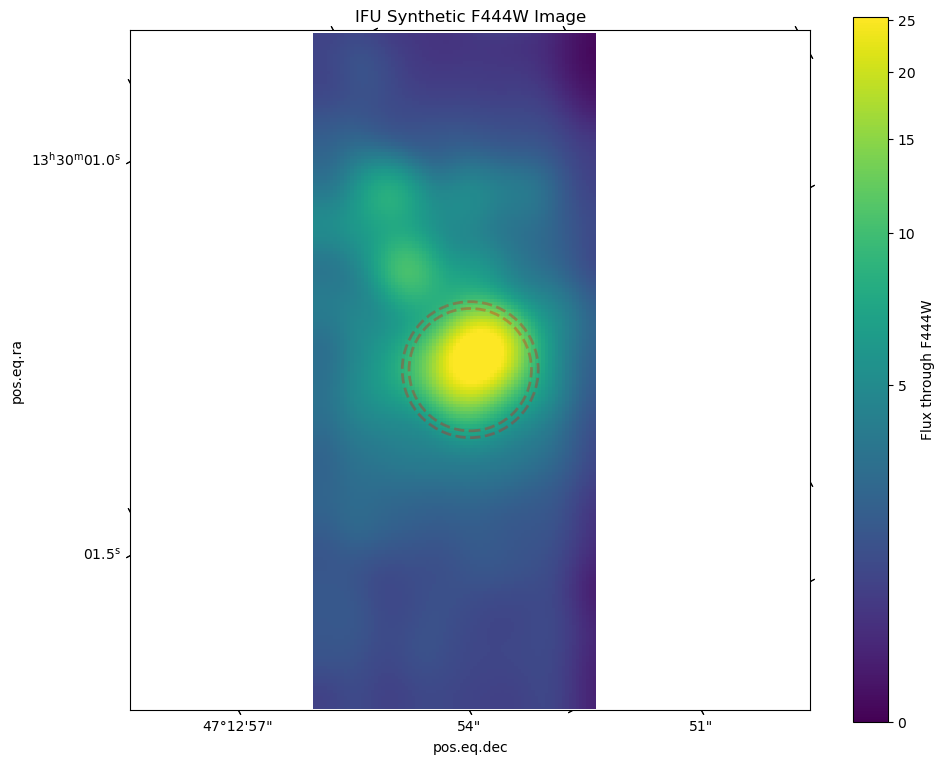

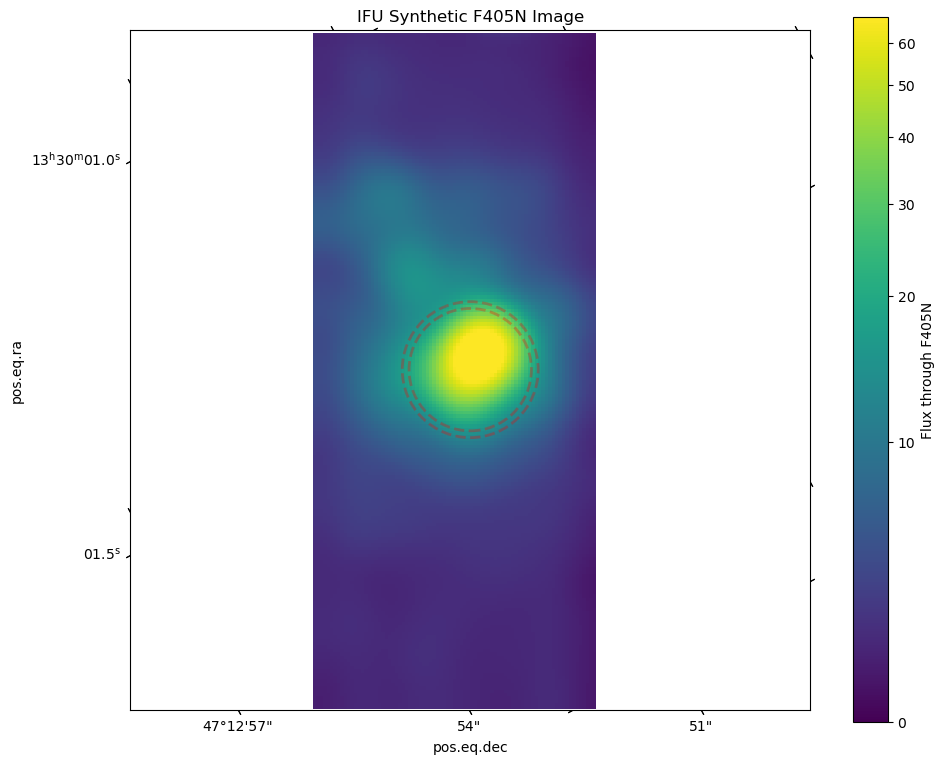

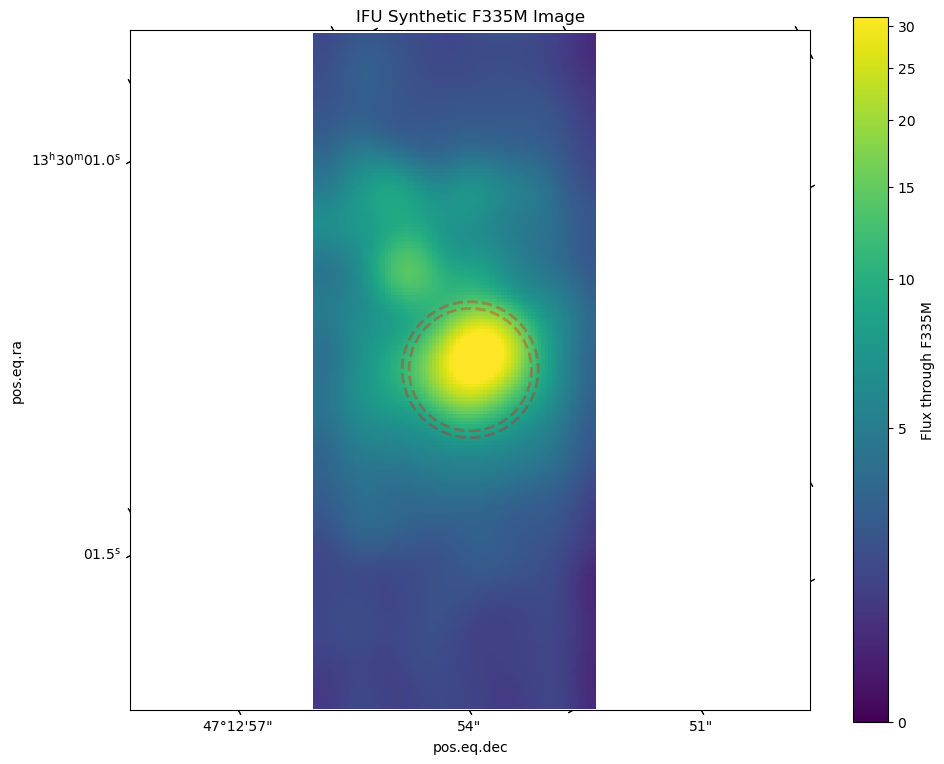

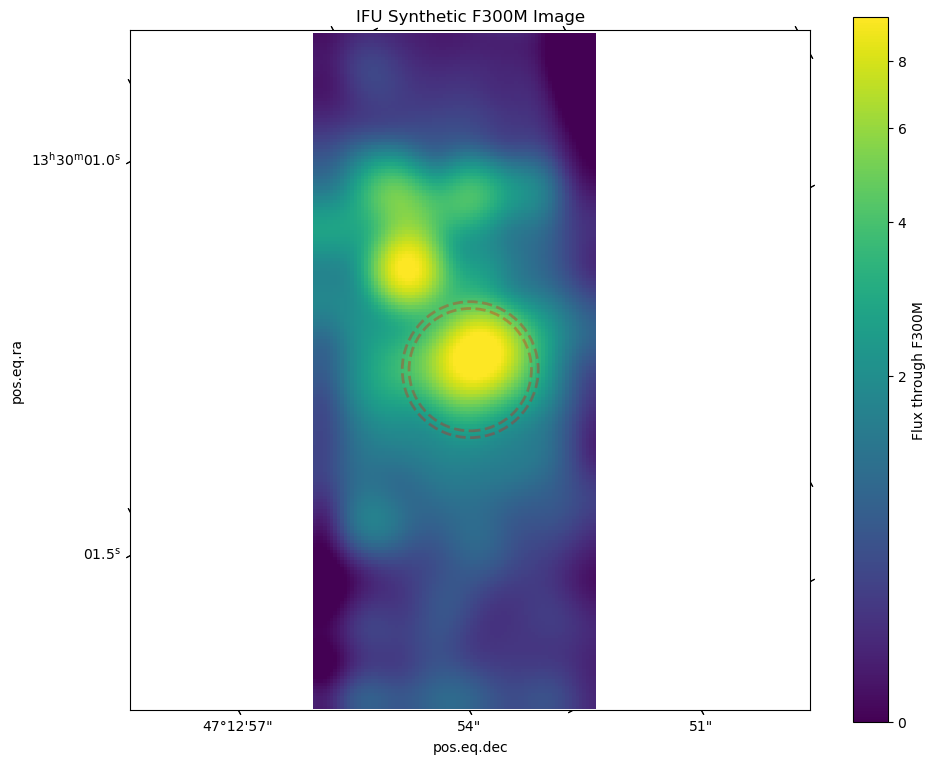

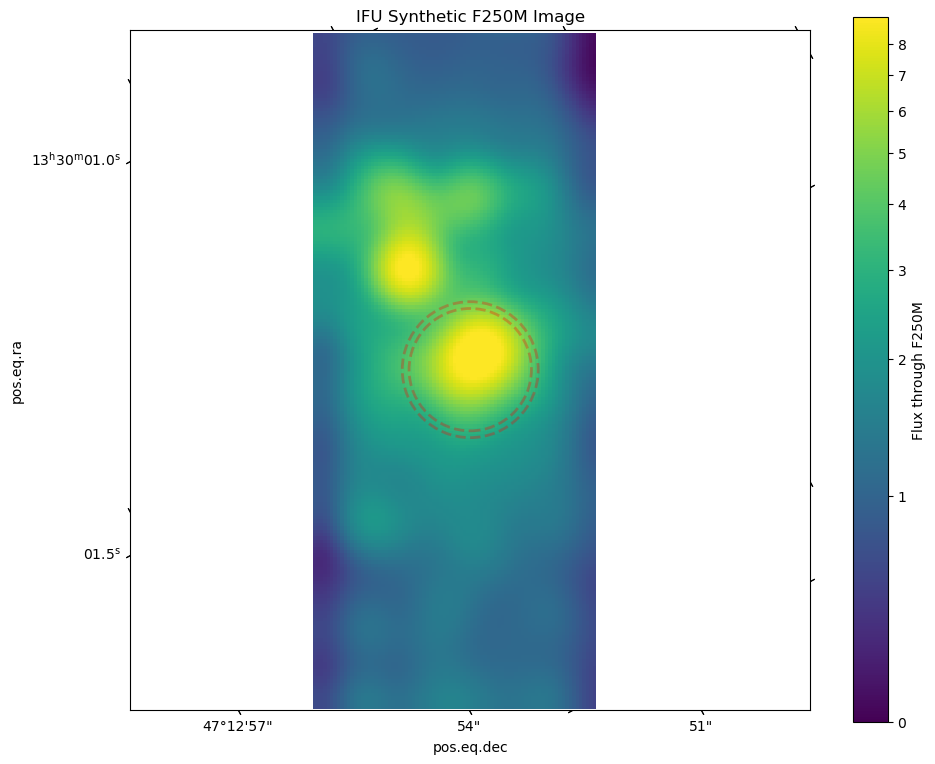

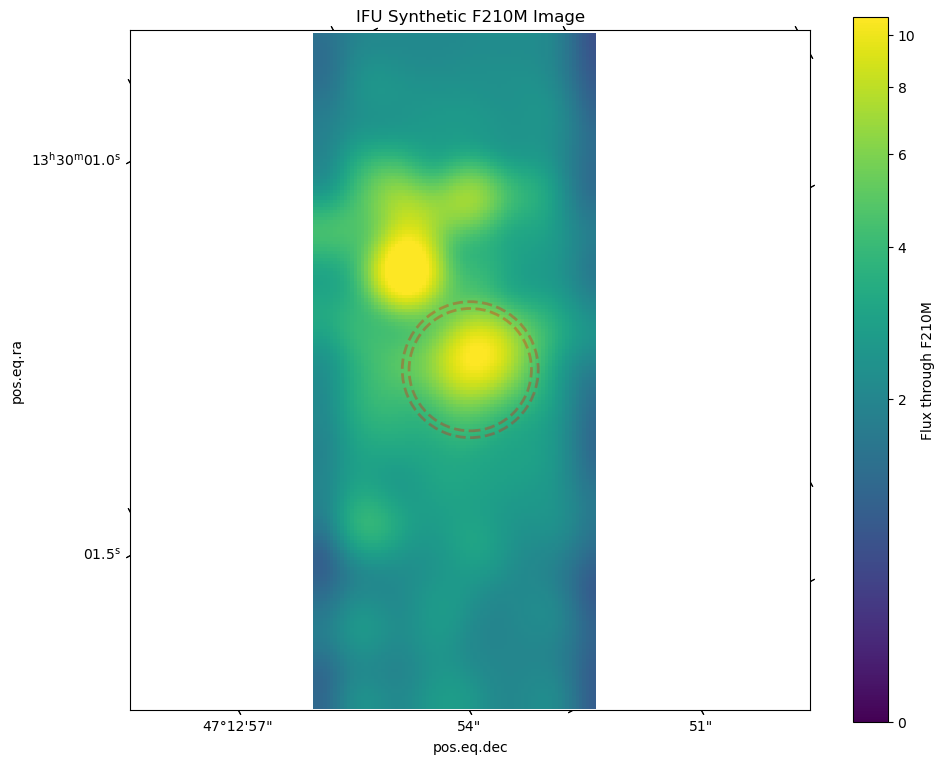

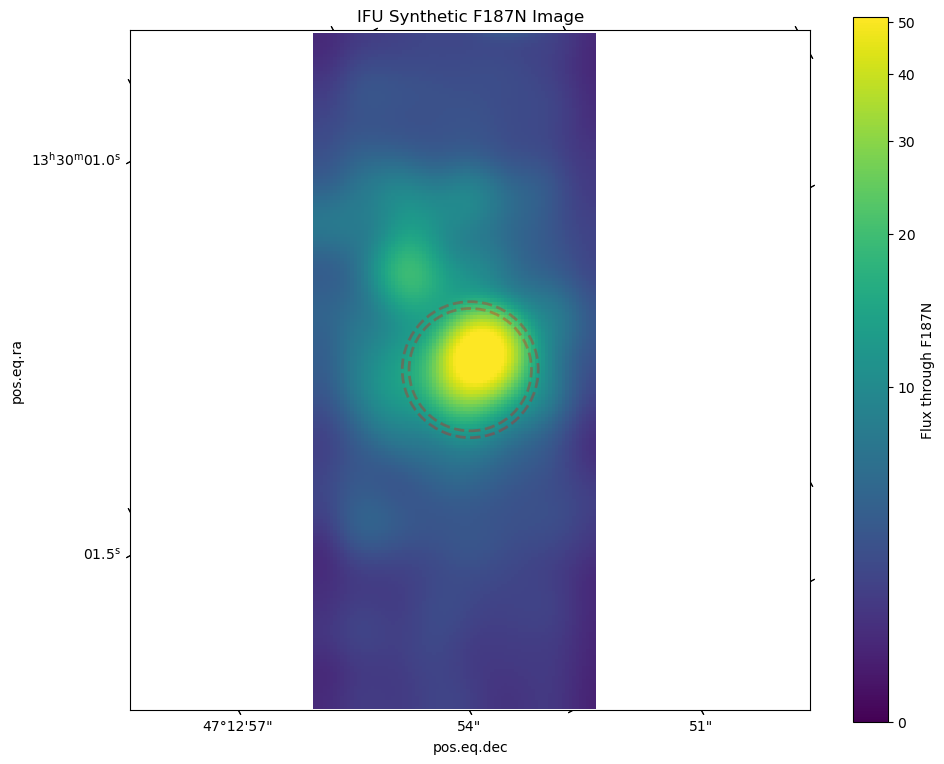

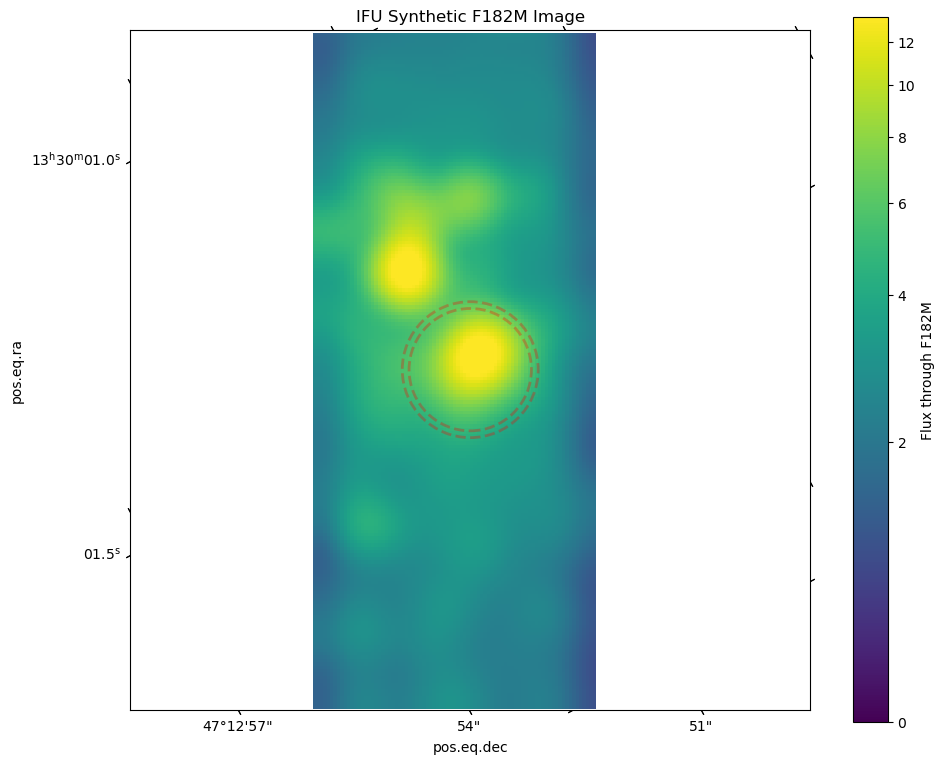

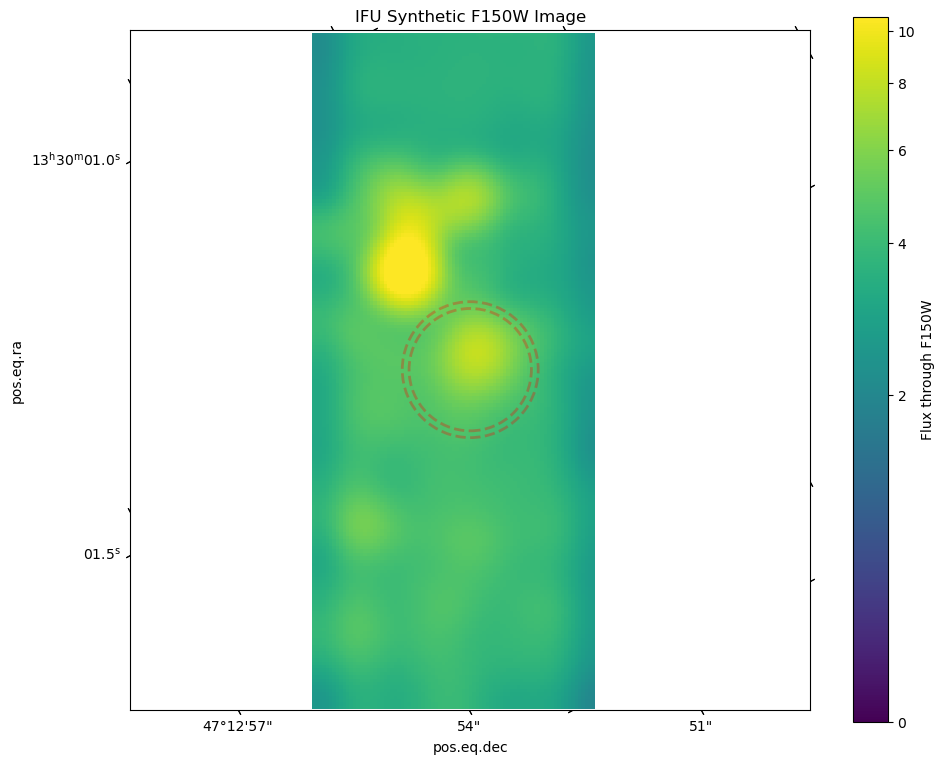

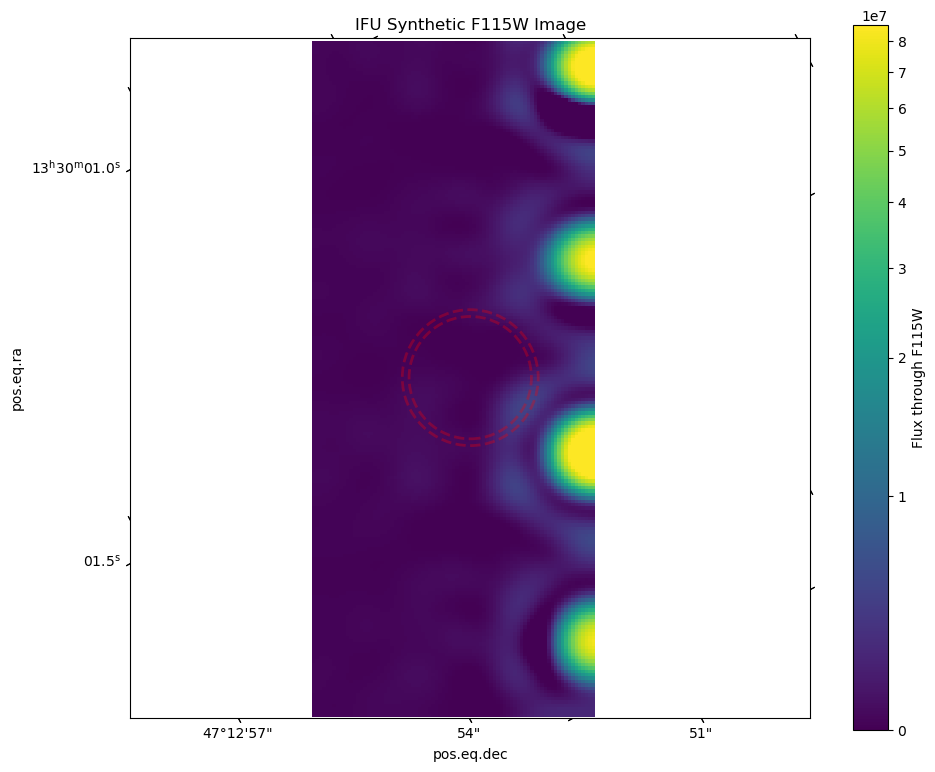

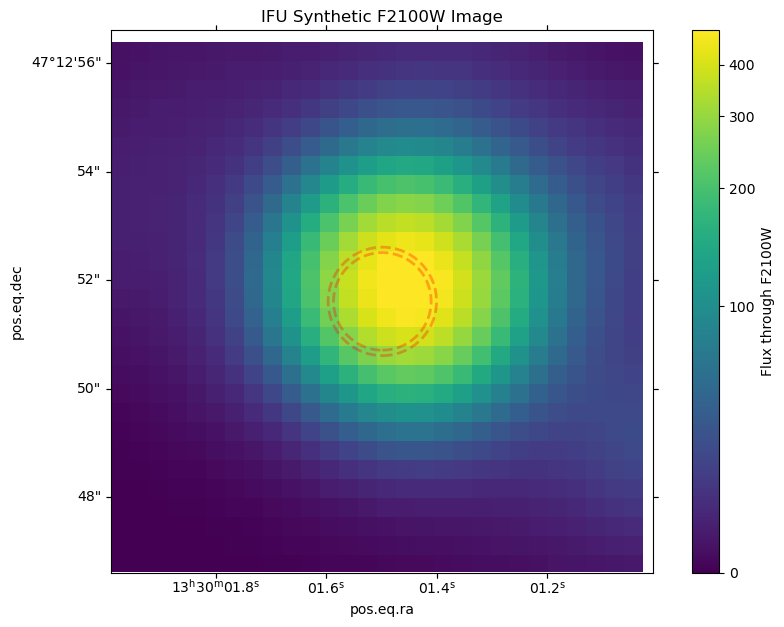

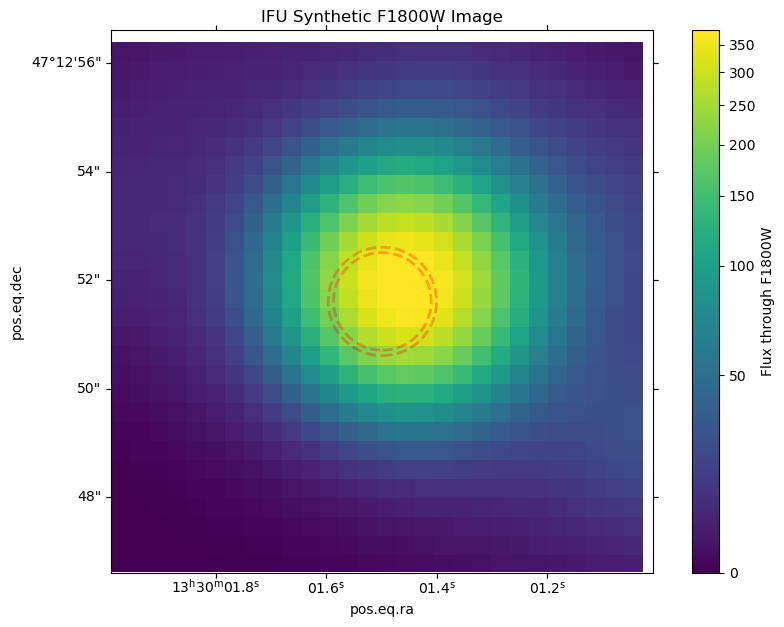

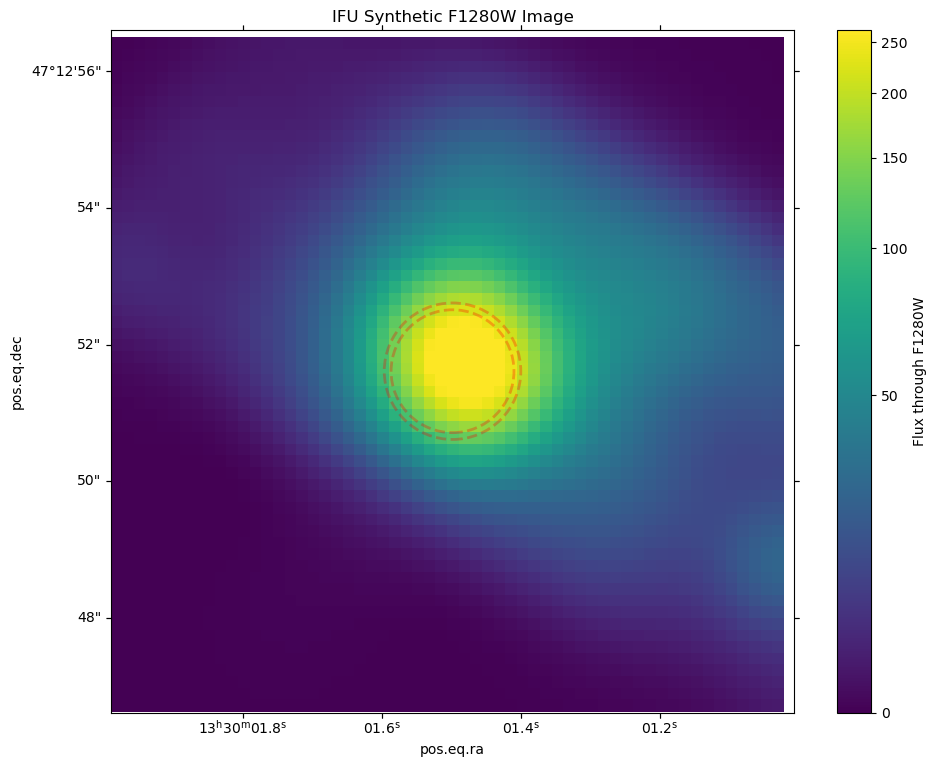

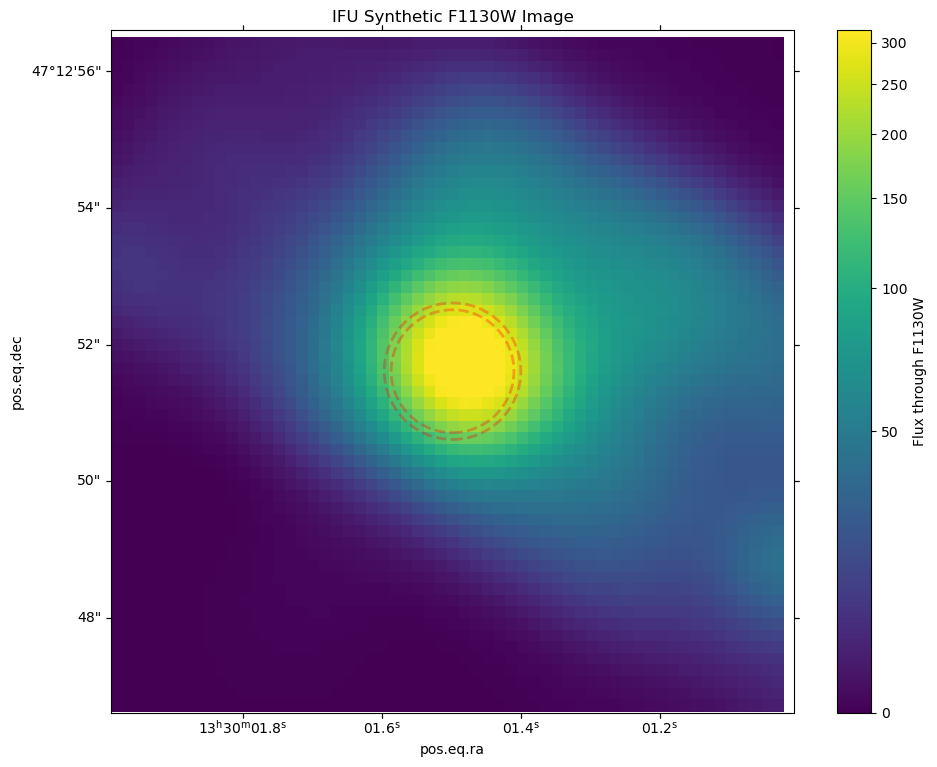

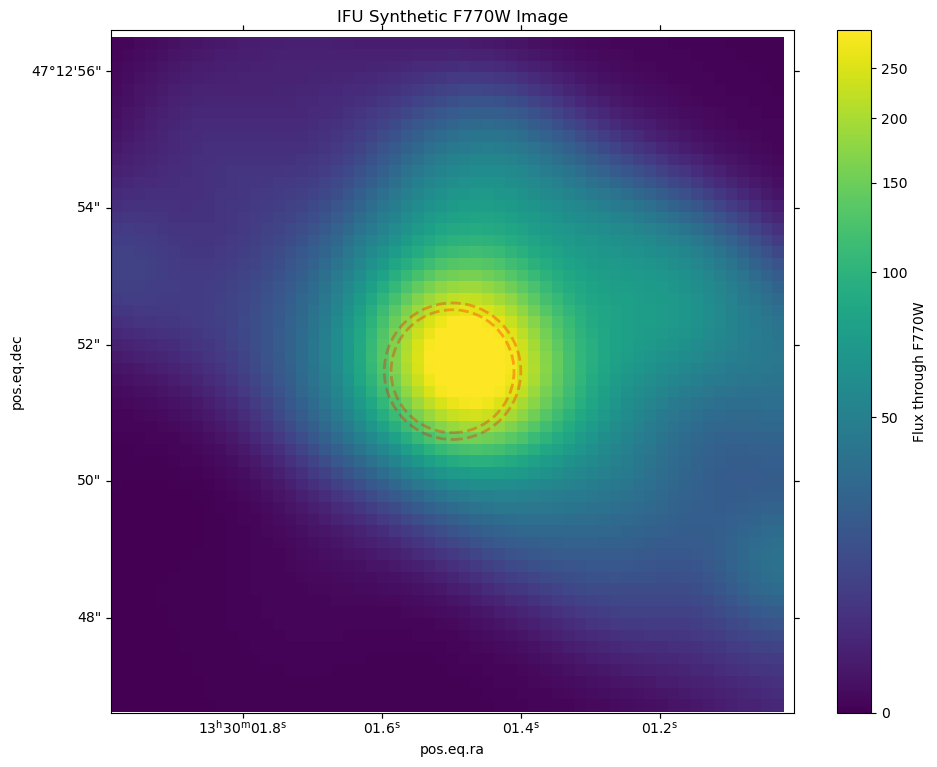

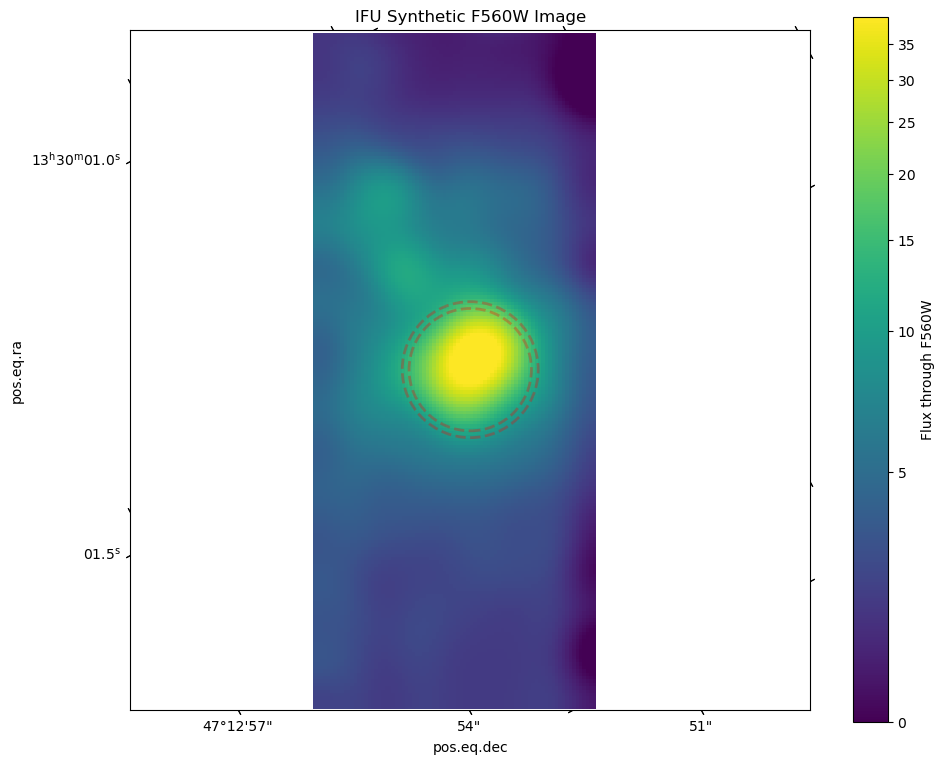

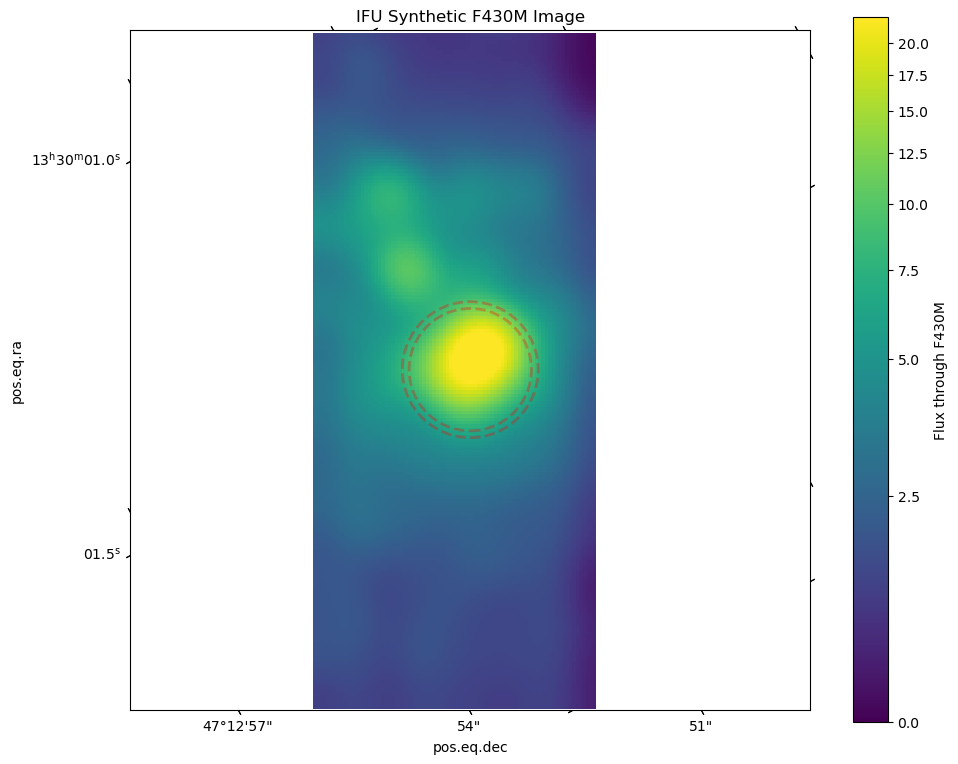

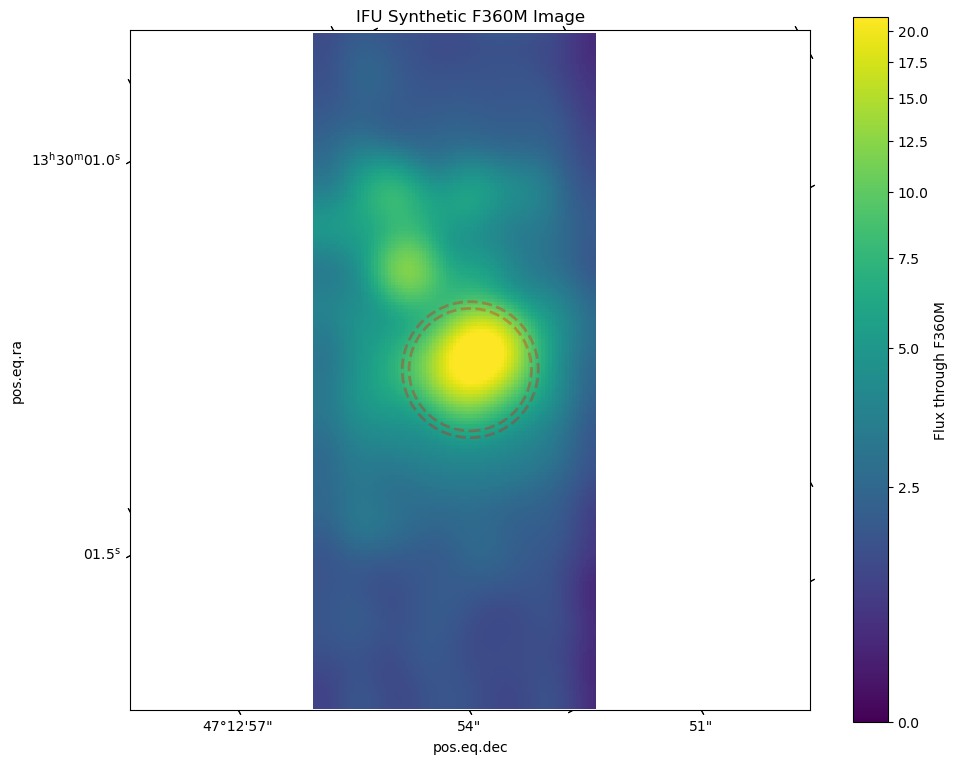

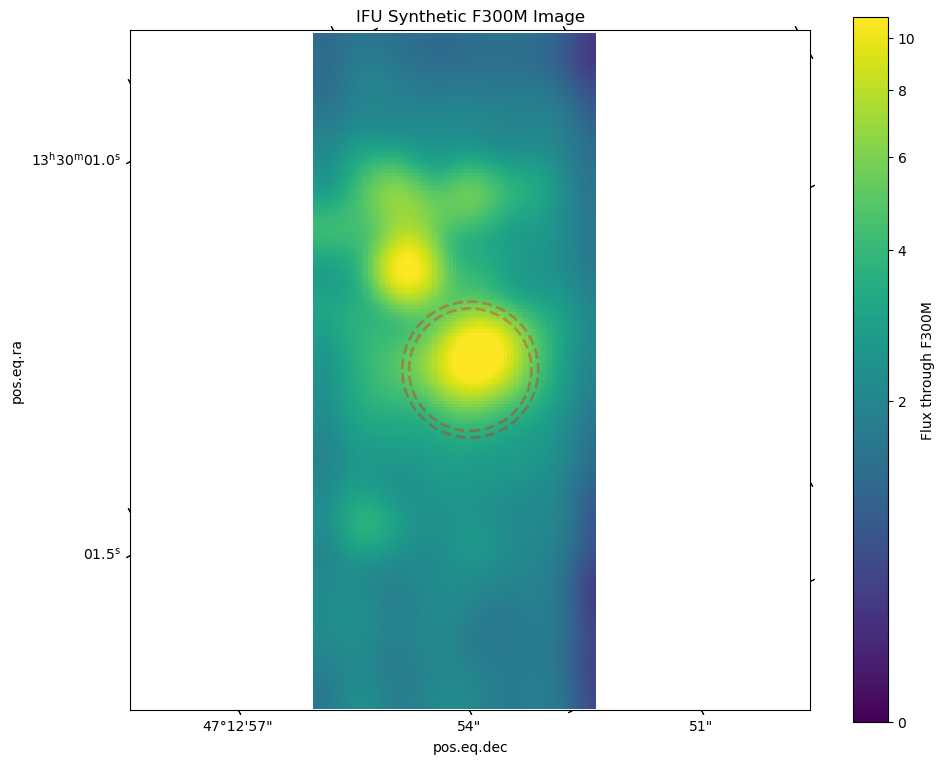

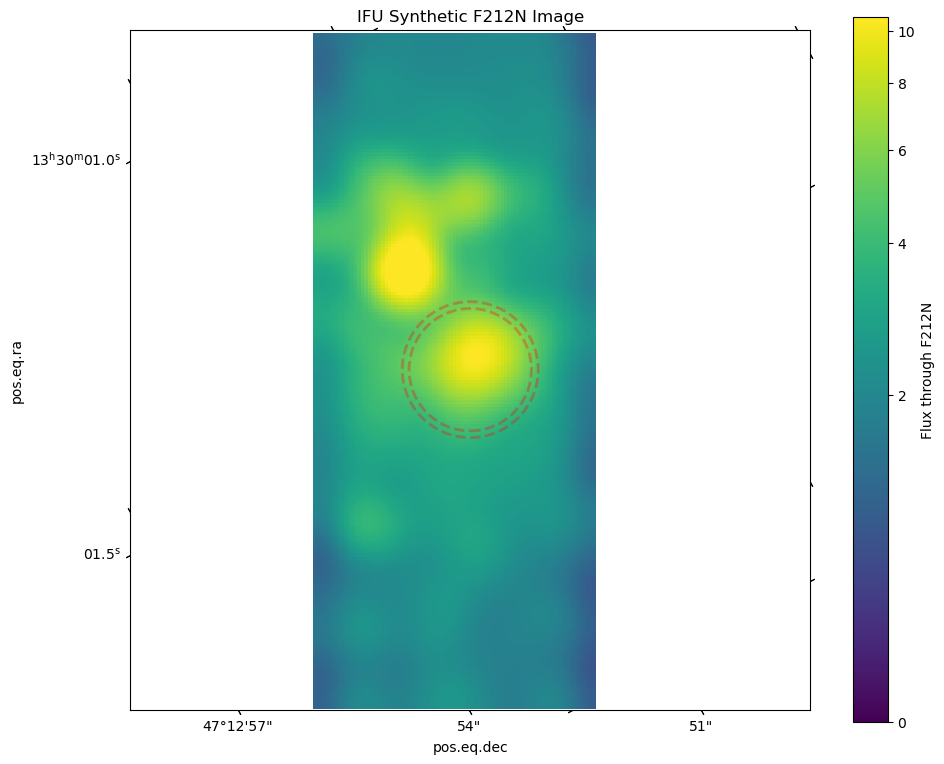

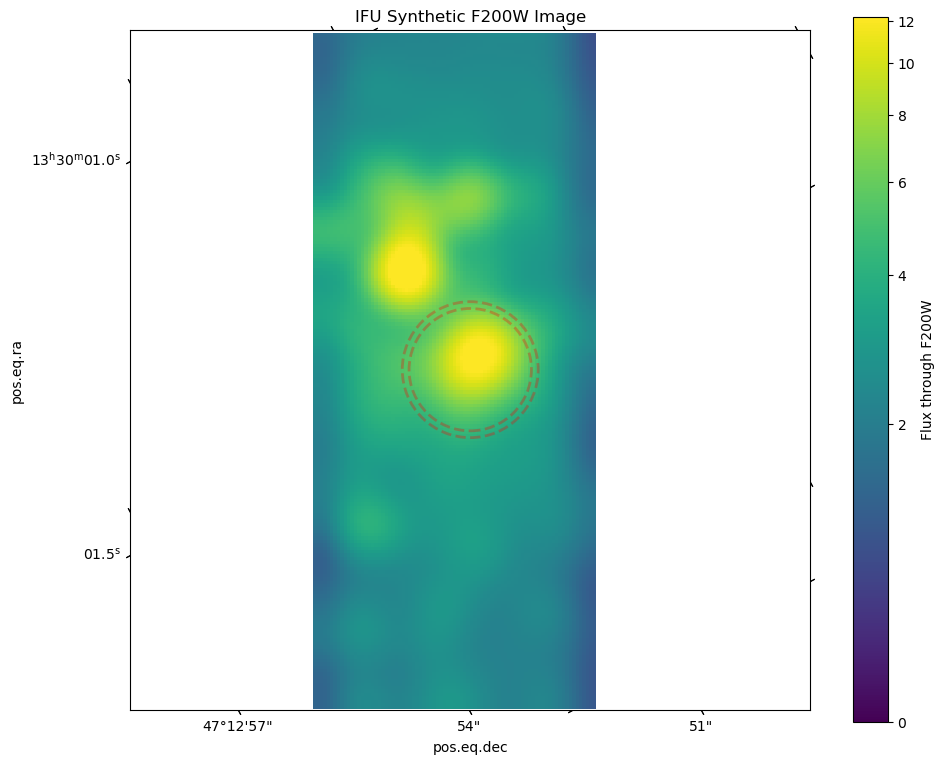

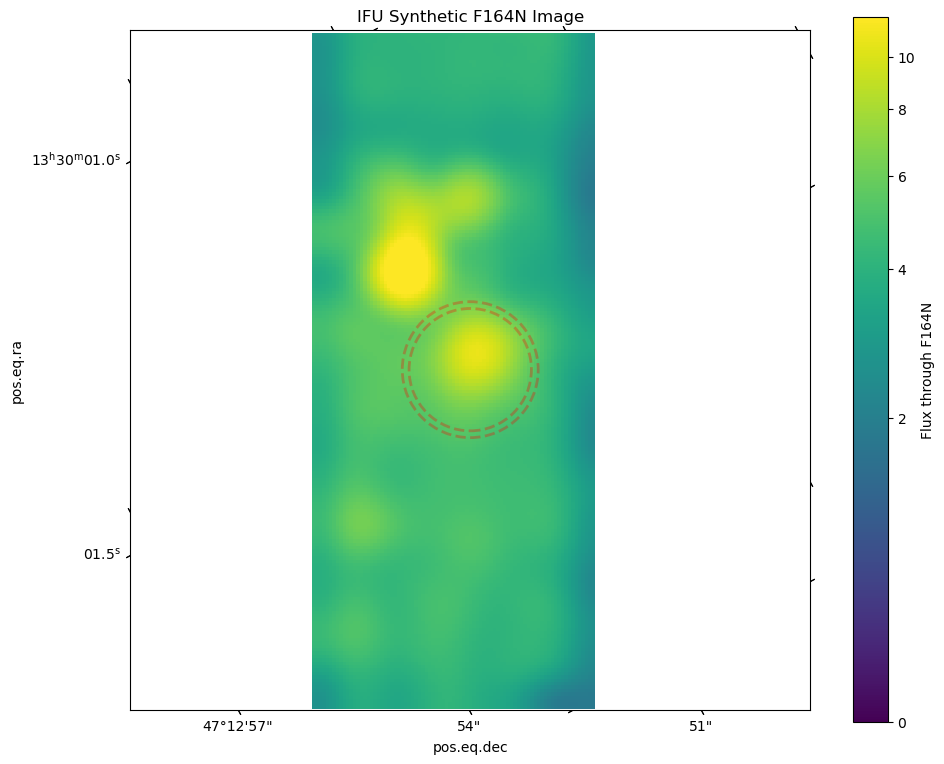

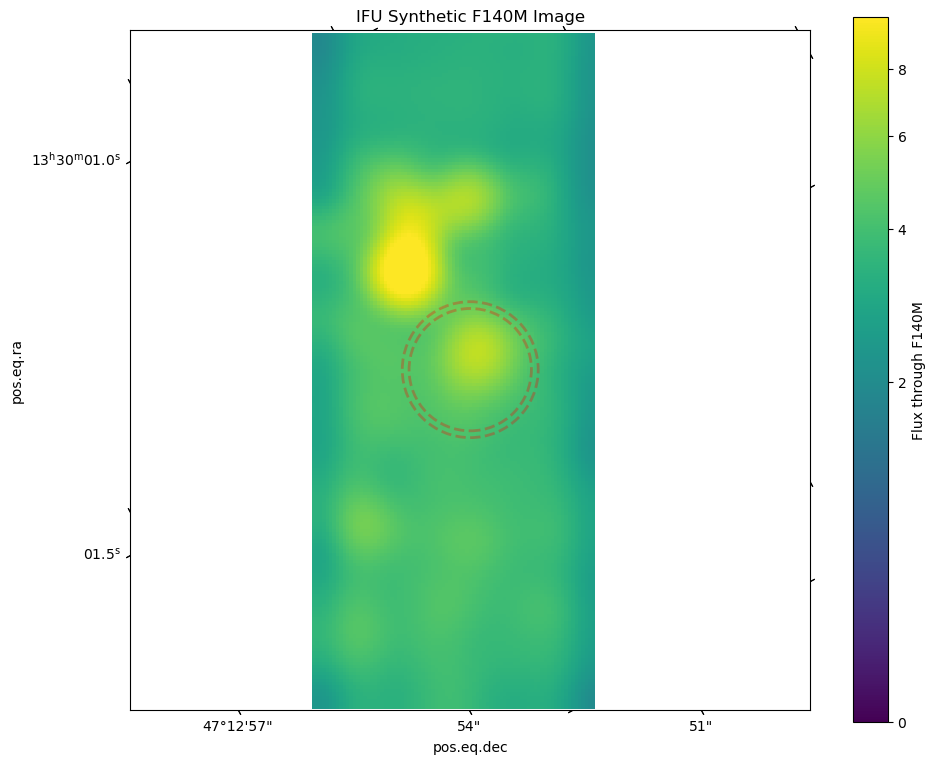

In [7]:
#This cell displays images of the IFU and image for verifying locations
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from astropy.nddata import block_reduce

def show_image(image_file, loc, radius, zoom_scale=5):
    """Display wavelength-integrated IFU data alongside 2D image."""
    
    # Load and integrate IFU data
    try:
        f = fits.open(image_file)['SCI']
    except:
        f = fits.open(image_file)[0]
    image_data = f.data
    image_header = f.header
    image_wcs = WCS(image_header, naxis=2)
    # Convert location to pixels
    loc_sky = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg, frame='icrs')
    x_img, y_img = image_wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)

    # Create figure
    fig = plt.figure(figsize=(15, 7))
    
    ax2 = fig.add_subplot(122, projection=image_wcs)
    im2 = ax2.imshow(image_data, origin='lower', cmap='viridis',
                    norm=ImageNormalize(image_data/5, stretch=AsinhStretch(), vmin=0, vmax=np.percentile(image_data, 99)))
    fig.colorbar(im2, ax=ax2, label='Flux')
    ax2.set_title(f"img : {image_file.split('/')[-1]}")


    pixel_scale = np.abs(image_wcs.wcs.cdelt[0]) * 3600  # arcsec/pixel
    radius_pix = radius.to(u.arcsec).value / pixel_scale
    in_radius_pix = (radius-0.1*u.arcsec).to(u.arcsec).value / pixel_scale
    ax2.add_patch(Circle((x_img, y_img), radius_pix, ec='red', fc='none', lw=2, ls='--', alpha = 0.3))
    ax2.add_patch(Circle((x_img, y_img), in_radius_pix, ec='red', fc='none', lw=2, ls='--', alpha = 0.3))
    
    # Set zoom (5x aperture radius by default)
    zoom_width = zoom_scale * radius_pix
    ax2.set_xlim(x_img - zoom_width, x_img + zoom_width)
    ax2.set_ylim(y_img - zoom_width, y_img + zoom_width)
    
    plt.suptitle(f"Aperture Radius: {radius}", y=0.95)
    plt.tight_layout()
    plt.show()

def show_IFU(ifu_file, filter_name, loc, radius, zoom_scale=5):
    """Display IFU data convolved to match a specified filter's transmission profile.
    
    Parameters
    ----------
    ifu_file : str
        Path to the IFU FITS file
    filter_name : str
        JWST filter name (e.g., 'F150W', 'F2100W')
    loc : list or SkyCoord
        [RA, Dec] in degrees or SkyCoord object for center position
    radius : Quantity
        Aperture radius (e.g., 1*u.arcsec)
    zoom_scale : float
        Zoom factor relative to aperture radius (default: 5)
    """
    
    # Load IFU data
    cube = SpectralCube.read(ifu_file, hdu='SCI')
    wcs = cube.wcs.celestial
    
    # Get filter transmission curve
    filter_files_maybe = [filt for filt in filter_files if extract_filter_name(filt).upper() == filter_name]
    if not filter_files_maybe:
        print(f"No matching image for filter {filter_name}")
    filter_file = filter_files_maybe[0]

    filter_data = []
    with open(filter_file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
    if len(filter_data) < 2:
        print(f"Filter file {filter_file} seems empty or malformed.")

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    trans_wl_array = np.array([try_float(row[0]) * 1e-10 for row in filter_T])
    transmission_array = np.array([try_float(row[1]) for row in filter_T])

    # Convert location to pixels and determine display bounds
    loc_sky = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg, frame='icrs') if isinstance(loc, list) else loc
    x_center, y_center = wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)
    
    pixel_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # arcsec/pixel
    radius_pix = radius.to(u.arcsec).value / pixel_scale
    zoom_width = zoom_scale * radius_pix
    
    # Calculate bounds of the region we'll display
    x_min = max(0, int(x_center - zoom_width))
    x_max = min(cube.shape[2], int(x_center + zoom_width))
    y_min = max(0, int(y_center - zoom_width))
    y_max = min(cube.shape[1], int(y_center + zoom_width))
    
    # Create empty synthetic image (full size, but we'll only fill the display region)
    synthetic_image = np.full(cube.shape[1:], np.nan)
    
    # Only process pixels in the display region
    for i in range(y_min, y_max):
        for j in range(x_min, x_max):
            # Get spectrum for this spaxel
            spec_flux = cube.filled_data[:,i,j].value
            spec_wl = cube.spectral_axis.to(u.m).value

            # Calculate synthetic flux through filter
            try:
                synthetic_image[i,j] = get_Fnu_transmission(
                    spec_flux, spec_wl, 
                    transmission_array, trans_wl_array, warnings=False
                )
            except:
                synthetic_image[i,j] = np.nan
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=wcs)
    
    # Plot with sensible scaling (only using the region we processed)
    display_region = synthetic_image[y_min:y_max, x_min:x_max]
    vmax = np.nanpercentile(display_region[display_region > 0], 99)
    
    im = ax.imshow(synthetic_image, origin='lower', cmap='viridis',
                  norm=ImageNormalize(stretch=AsinhStretch(), vmin=0, vmax=vmax))
    fig.colorbar(im, ax=ax, label=f'Flux through {filter_name}')
    
    # Add aperture circles
    ax.add_patch(Circle((x_center, y_center), radius_pix, 
                       ec='red', fc='none', lw=2, ls='--', alpha=0.3))
    ax.add_patch(Circle((x_center, y_center), radius_pix-0.1/pixel_scale, 
                       ec='red', fc='none', lw=2, ls='--', alpha=0.3))
    
    # Set zoom
    ax.set_xlim(x_center - zoom_width, x_center + zoom_width)
    ax.set_ylim(y_center - zoom_width, y_center + zoom_width)
    
    ax.set_title(f"IFU Synthetic {filter_name} Image")
    plt.tight_layout()
    plt.show()

#show_image('Data_files/Image_files/Convolved_images/location_0/f200w_image_convolved_to_21um.fits', locations[0], 1*u.arcsec, zoom_scale=5)
#show_IFU('Data_files/IFU_files/Convolved_to_21um/F200W_ifu_convolved.fits', "F200W", locations[0], 1*u.arcsec, zoom_scale=5)
conv_image_files = glob.glob('Data_files/Image_files/Convolved_images/test*.fits')
conv_ifu_files = glob.glob('Data_files/IFU_files/Convolved_to_21um/test*.fits')
for file in conv_image_files:
    show_image(file, locations[0], 1*u.arcsec, zoom_scale=5)
for file in conv_ifu_files:
    filter_name = file.split("/")[-1].split("_")[1]
    show_IFU(file, filter_name, locations[0], 1*u.arcsec, zoom_scale=5)

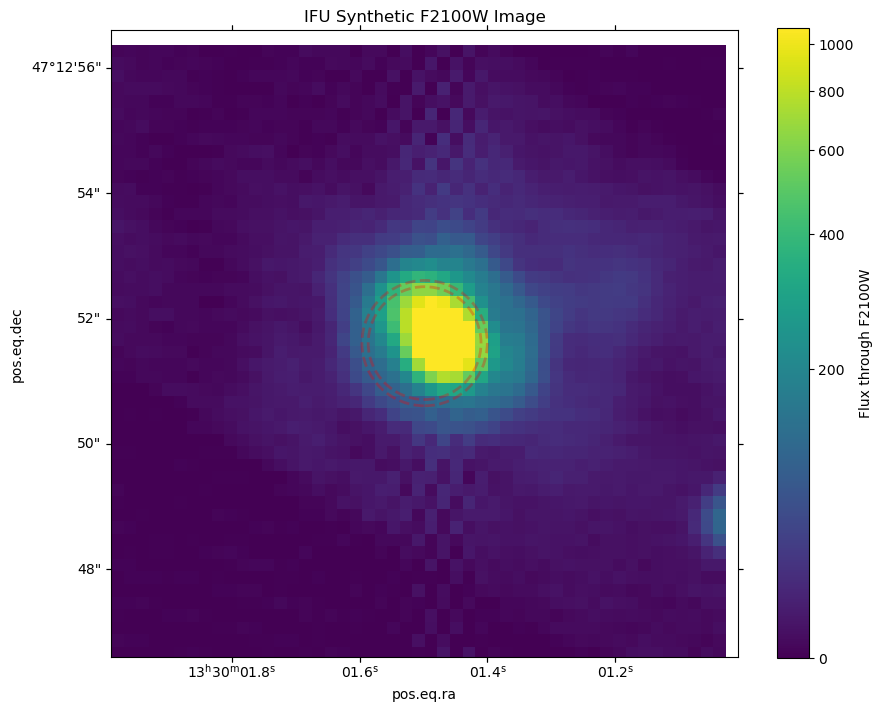

In [4]:
show_IFU(conv_ifu_files[-1], "F2100W", locations[0], 1*u.arcsec, zoom_scale=5)

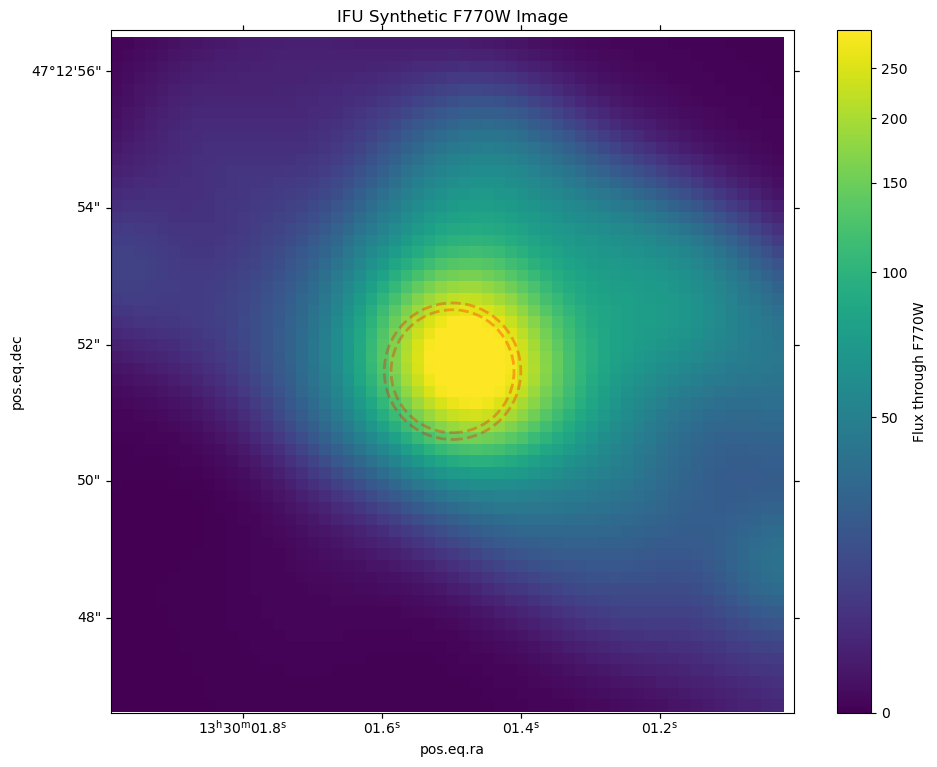

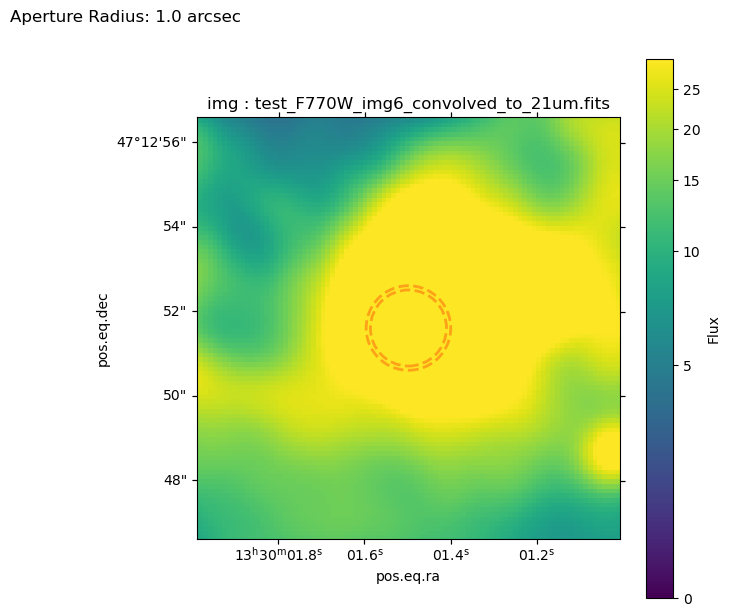

In [20]:
show_IFU('Data_files/IFU_files/Convolved_to_21um/test_F770W_IFU10_convolved_to_21um.fits', 'F770W', locations[0], 1*u.arcsec, zoom_scale=5)
show_image('Data_files/Image_files/Convolved_images/test_F770W_img6_convolved_to_21um.fits', locations[0], 1*u.arcsec, zoom_scale=5)

In [9]:
conv_ifu_files[0].split("/")[-1].split("_")[0]

'F430M'

In [19]:
conv_ifu_files

['Data_files/IFU_files/Convolved_to_21um/test_F2100W_IFU0_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F1800W_IFU2_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F1500W_IFU4_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F1280W_IFU5_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F1130W_IFU7_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F1000W_IFU9_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F770W_IFU11_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F560W_IFU12_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F444W_IFU14_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F405N_IFU16_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F335M_IFU18_convolved_to_21um.fits',
 'Data_files/IFU_files/Convolved_to_21um/test_F300M_IFU19_convolved_to_21um.fits',
 'Da

In [18]:
conv_image_files

['Data_files/Image_files/Convolved_images/test_F2100W_img0_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F1800W_img1_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F1500W_img2_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F1280W_img3_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F1130W_img4_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F1000W_img5_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F770W_img6_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F560W_img7_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F444W_img8_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F430M_img9_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F405N_img10_convolved_to_21um.fits',
 'Data_files/Image_files/Convolved_images/test_F360M_img11_convolved_to_21um.fit